# Once Upon a Time: Interactive Learning for Storytelling with Small Language Models
Supplementary Code by Jonas Mayer Martins

Visualization script

August 2025

## Helper functions

In [2]:
# Plotting util functions
import PyPDF2
import os
import matplotlib.pyplot as plt
os.environ['MallocStackLogging'] = '0'

def init_latex(fontsize):
    # LaTeX fonts, paper figure sizing utilities
    os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": fontsize,
        "font.size": fontsize,
        "legend.fontsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "lines.solid_capstyle": "round"
    })

def set_size(width_pt=451, ncols=2, fraction=1, aspect_ratio=None):
    # ncols:
    # 1: one-column wide figure in two-column environment
    # 2: two-column wide figure in two-column environment
    if ncols == 1:
        width_pt = 217 # pts
    elif ncols == 2:
        width_pt = 451 # pts
    else:
        print(f"Using default widht of {width_pt} pts.")
    fig_width_pt = width_pt * fraction
    #cm_per_pt = 0.03528
    in_per_pt = 0.013889
    if aspect_ratio is None:
        aspect_ratio = (5**.5 - 1) / 2  # Golden ratio
    fig_width_in = fig_width_pt * in_per_pt
    fig_height_in = fig_width_in * aspect_ratio
    return (fig_width_in, fig_height_in)

def check_pdf_size(filename, figsize, fraction):
    """
    Saving with bbox_inches='tight', e.g.,
    plt.savefig("figs/BLM_eval_fast.pdf", bbox_inches='tight', pad_inches=0)
    yields a smaller figsize than expected when setting figsize at the top. Thus compare and set fraction with set_size.
    """
    # Open PDF and get its MediaBox size (in points)
    with open(filename, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        page = reader.pages[0]
        width_pts = float(page.mediabox.width)
        height_pts = float(page.mediabox.height)
    in_per_pt = 1 / 72.0
    width_in  = width_pts * in_per_pt
    height_in = height_pts * in_per_pt

    print(f"=== PDF actual area ===:")
    print(f"  {width_pts:.2f}pt x {height_pts:.2f}pt  ||  {width_in:.4f}in x {height_in:.4f}in")

    print(f"=== Your target figsize from set_size, corrected for fraction:")
    print(f"  {figsize[0]*72/fraction:.2f}pt x {figsize[1]*72/fraction:.2f}pt  ||  {figsize[0]/fraction:.4f}in x {figsize[1]/fraction:.4f}in")

    print(f"=== Ratio (actual/target):")
    print(f"  width: {width_pts/(figsize[0]*72/fraction):.2%},  height: {height_pts/(figsize[1]*72/fraction):.2%}")
    return width_in, height_in, width_pts, height_pts


fontsize = 11
init_latex(fontsize)

## PPO Training

In [1]:
import os
import re
import yaml
import pandas as pd
from pathlib import Path

# Constants (adapt as needed)
DATA_ROOT = "data_ppo_training"
META_DATA_DIR = "meta_data"
BATCH_STATS_FILE = "batch_stats.csv"
GENERATED_FILE = "generated.csv"
CONFIG_FILE = "ppo.yaml"
CHECKPOINT_PATTERN = r"chck_(\d+)M"
SEED_PATTERN = r"seed(\d+)"

def find_checkpoints(data_root):
    """Finds all subfolders matching 'chck_...M' pattern and returns their paths and revision numbers."""
    results = []
    for entry in Path(data_root).iterdir():
        if entry.is_dir():
            match_rev = re.search(CHECKPOINT_PATTERN, entry.name)
            match_seed = re.search(SEED_PATTERN, entry.name)
            if match_rev:
                revision = match_rev.group(1)  # e.g., 90
                seed = int(match_seed.group(1)) if match_seed else None
                results.append((entry, revision, seed))
    return results

def extract_scores(text):
    score_regex = re.compile(r"\b(\d)\b[ ,]+(\d)\b[ ,]+(\d)\b")
    m = score_regex.search(str(text))
    if m:
        s1, s2, s3 = (int(x) for x in m.groups())
        return pd.Series([s1, s2, s3, s1 + s2 + s3, (s1 + s2 + s3) / 9],
                         index=['Readability', 'Coherence', 'Creativity', 'score_sum', 'teacher_reward_from_generate'])
    else:
        return pd.Series([None] * 5, index=['Readability', 'Coherence', 'Creativity', 'score_sum', 'teacher_reward_from_generate'])

def process_generated_csv(path_to_csv):
    df = pd.read_csv(path_to_csv)
    score_fields = df['teacher_output'].apply(extract_scores)
    df = pd.concat([df, score_fields], axis=1)
    df['story_length'] = df['student_output'].astype(str).str.split().apply(len)
    return df

def process_batch_stats_csv(path_to_csv):
    return pd.read_csv(path_to_csv)

def load_config_yaml(path_to_yaml):
    with open(path_to_yaml, "r") as f:
        return yaml.safe_load(f)

def batch_score_aggregation(df_generated, batch_size):
    """
    For each batch (N stories), computes the mean and std of the scores,
    and also the per-batch fractions for every score value (e.g., Readability_count_0, etc).
    Prepends 'avg_' and 'std_' to column names.
    Returns a DataFrame with all these stats concatenated.
    """
    score_cols = ['Readability', 'Coherence', 'Creativity', 'score_sum', 'teacher_reward_from_generate']
    main_score_cols = ['Readability', 'Coherence', 'Creativity']
    possible_values = [0, 1, 2, 3]  # adjust as appropriate

    df_nonan = df_generated.dropna(subset=score_cols).reset_index(drop=True)
    batches = (df_nonan.index // batch_size)
    grouped = df_nonan.groupby(batches)

    # Means & stds
    batch_means = grouped[score_cols].mean().reset_index(drop=True)
    batch_stds  = grouped[score_cols].std().reset_index(drop=True)
    batch_means = batch_means.rename(columns={col: f"avg_{col}" for col in score_cols})
    batch_stds  = batch_stds.rename(columns={col: f"std_{col}" for col in score_cols})

    # Fractions (proportions) of each possible value for each score column
    fractions = {}
    for score in main_score_cols:
        for value in possible_values:
            # For each batch, compute fraction of entries equal to `value`
            name = f"{score}_count_{value}"
            # Here, value_counts() alone is not enough; use apply
            props = grouped[score].apply(lambda x: (x == value).sum() / len(x) if len(x) > 0 else 0)
            fractions[name] = props.values

    fractions_df = pd.DataFrame(fractions)

    # Concatenate all together: means, stds, and value fractions
    batch_scores = pd.concat([batch_means, batch_stds, fractions_df], axis=1)
    return batch_scores

def get_revision(df, revision):
    """
    Returns the dataframe for a given revision number (90, 200, 500)
    """
    return df[df["revision_number"] == str(revision)]

checkpoints = find_checkpoints(DATA_ROOT)
print(f"Found {len(checkpoints)} checkpoints.")

batch_stats_dict_all_seeds = {}
generated_dict_all_seeds = {}

batch_stats_dict = {}
generated_dict = {}

for checkpoint_path, revision_number, rl_seed in checkpoints:
    meta_data_path = checkpoint_path / META_DATA_DIR
    gen_file = meta_data_path / GENERATED_FILE
    batch_file = meta_data_path / BATCH_STATS_FILE
    config_file = meta_data_path / CONFIG_FILE

    if not (gen_file.exists() and batch_file.exists() and config_file.exists()):
        print(f"Skipping {checkpoint_path.name}: missing files.")
        continue

    # Load per-checkpoint config for batch size
    config = load_config_yaml(config_file)
    batch_size = config.get("batch_size", None)
    if batch_size is None:
        print(f"Config for {checkpoint_path.name} missing 'batch_size'. Skipping.")
        continue

    df_generated = process_generated_csv(gen_file)
    df_batch = process_batch_stats_csv(batch_file)

    # Remove specified field, rename columns
    if 'new_old_ratio' in df_batch.columns:
        df_batch = df_batch.drop(columns=['new_old_ratio'])
    batch_rename_map = {
        'mean_total_reward': 'avg_total_reward',
        'mean_non_reward': 'avg_non_reward'
    }
    df_batch = df_batch.rename(columns=batch_rename_map)

    df_batch['interaction_round'] = list(df_batch.index * batch_size) # add interaction_round as variable

    # Batch-aggregate readability etc. scores
    batch_scores = batch_score_aggregation(df_generated, batch_size)

    # Merge them side by side (ensure same length/order)
    df_combined = pd.concat(
        [df_batch.reset_index(drop=True), batch_scores.reset_index(drop=True)], axis=1
    )

    # Store in all-seed dicts
    batch_stats_dict_all_seeds[(revision_number, rl_seed)] = df_combined
    generated_dict_all_seeds[(revision_number, rl_seed)] = df_generated

    # Store only seed==42 in legacy dicts
    if rl_seed == 42:
        batch_stats_dict[revision_number] = df_combined
        generated_dict[revision_number] = df_generated


    print(f"Processed {checkpoint_path.name}: {len(df_generated)} stories, {len(batch_scores)} batches.")

# Collate all seeds into DataFrames
df_batch_all_seeds = pd.concat(
    [df.assign(revision_number=rev, RL_seed=seed)
     for (rev, seed), df in batch_stats_dict_all_seeds.items()],
    ignore_index=True
)
df_generated_all_seeds = pd.concat(
    [df.assign(revision_number=rev, RL_seed=seed)
     for (rev, seed), df in generated_dict_all_seeds.items()],
    ignore_index=True
)

# Legacy variables: only seed 42
df_batch = pd.concat(
    [df.assign(revision_number=rev, RL_seed=42)  # all are RL_seed=42
     for rev, df in batch_stats_dict.items()],
    ignore_index=True
)
df_generated = pd.concat(
    [df.assign(revision_number=rev, RL_seed=42)
     for rev, df in generated_dict.items()],
    ignore_index=True
)

length_coeff = 0.4
df_generated_all_seeds['teacher_and_length_reward'] = (
    df_generated_all_seeds['score_sum'] / 9 +
    length_coeff * df_generated_all_seeds['story_length'] / 100
) / (1 + length_coeff)

df_generated['teacher_and_length_reward'] = (
    df_generated['score_sum'] / 9 +
    length_coeff * df_generated['story_length'] / 100
) / (1 + length_coeff)


print("\nSample batch stats (seed 42 only):")
print(df_batch.head())


Found 8 checkpoints.
Processed blm-gpt2s-90M-s42_chck_900M_ppo-1000K-seed42__2025-08-14__11-01-33: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_90M_ppo-1000K-seed42__2025-08-14__13-54-57: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_50M_ppo-1000K-seed42__2025-08-14__11-49-23: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_200M_ppo-1000K-seed42__2025-08-14__17-19-05: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_20M_ppo-1000K-seed42__2025-08-14__12-11-06: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_900M_ppo-1000K-seed44__2025-08-14__19-01-45: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_900M_ppo-1000K-seed43__2025-08-14__18-38-26: 331200 stories, 920 batches.
Processed blm-gpt2s-90M-s42_chck_500M_ppo-1000K-seed42__2025-08-14__14-56-07: 331200 stories, 920 batches.

Sample batch stats (seed 42 only):
   avg_teacher_reward  std_teacher_reward  avg_length_bonus  std_length_bonus  \
0        

#### Look at example stories

In [3]:
# Sort by total score (descending) and take the top 5
# Sort by total score_sum (descending), then by teacher_and_length_reward (descending)
top_stories = df_generated.sort_values(
    ['teacher_and_length_reward','score_sum', ],
    ascending=[False, False]
).head(5)

for idx, row in top_stories.iterrows():
    print(f"Score: {row['score_sum']} | Reward: {row['teacher_and_length_reward']:.2f} | Story Length: {row['story_length']} | Interaction: {idx} |Model: {row['revision_number']} M")
    print(row['student_output'])
    print('-' * 80)

top_stories[['student_output', 'score_sum', 'Readability', 'Coherence', 'Creativity', 'story_length']]

Score: 8.0 | Reward: 0.85 | Story Length: 76 | Interaction: 8820 |Model: 900 M
 everything seemed as if it were a fairy tale—so much as you have told us a great story that we cannot bear to believe. There was something, however, very different from the description of the whole story, most surprising. If the story reached out, then, and it was always the story at the end, it was always something inexpressibly a story that made a great deal of sense. But it was all a mistake and wonder
--------------------------------------------------------------------------------
Score: 8.0 | Reward: 0.85 | Story Length: 76 | Interaction: 255512 |Model: 900 M
 a man of small experience had disposed of the delights and magnitude of the soul, and could have been recollected elsewhere, somehow or other. Even when the flame over his forehead fell, he had felt hardly any change in his eyes. He had never seen so beautiful a human being before. And every person must be looking at him, in spite of him or her o

,student_output,score_sum,Readability,Coherence,Creativity,story_length
8820,everything seemed as if it were a fairy tale—...,8.0,2.0,3.0,3.0,76
255512,a man of small experience had disposed of the...,8.0,2.0,3.0,3.0,76
245523,"I told the traveller to try some hard thing, ...",8.0,2.0,3.0,3.0,74
241088,"a man, who pushed his sick vulture from some ...",8.0,2.0,3.0,3.0,72
279225,"in a lower almost hole, there was little hope...",8.0,2.0,3.0,3.0,71


In [4]:
import numpy as np

# Set random seed and model size
seed = 42
selected_model_size = 900  # change as needed

np.random.seed(seed)

# Filter and reindex the DataFrame for the selected model
df_model = df_generated[df_generated['revision_number'] == str(selected_model_size)].reset_index(drop=True)
df_model.index = df_model.index + 1  # make index start at 1

n = len(df_model)
if n == 0:
    print(f"No stories found for model size {selected_model_size}M.")
else:
    # Calculate split indices
    first_third_end = n // 3
    second_third_end = 2 * n // 3

    # Split into thirds
    first_third = df_model.iloc[:first_third_end]
    second_third = df_model.iloc[first_third_end:second_third_end]
    last_third = df_model.iloc[second_third_end:]

    def random_story(df_section):
        return df_section.sample(n=1).iloc[0]

    def best_story(df_section):
        return df_section.sort_values(
            ['teacher_and_length_reward', 'score_sum'],
            ascending=[False, False]
        ).head(1).iloc[0]

    # Select required stories
    rand_first = random_story(first_third)
    rand_second = random_story(second_third)
    rand_last = random_story(last_third)
    overall_best = best_story(df_model)

    # Prepare output
    selections = [
        ('First third (random)', rand_first),
        ('Second third (random)', rand_second),
        ('Last third (random)', rand_last),
        ('Overall best', overall_best)
    ]

    for label, story in selections:
        print(f"{label} (Interaction: {story.name}):")
        print(f"Score: {story['score_sum']} | Reward: {story['teacher_and_length_reward']:.2f} | Story Length: {story['story_length']} | Readability {int(story['Readability'])} | Coherence {int(story['Coherence'])} | Creativity {int(story['Creativity'])} | Model: {story['revision_number']} M")
        print(story['student_output'])
        print('-' * 80)

First third (random) (Interaction: 43434):
Score: 5.0 | Reward: 0.61 | Story Length: 76 | Readability 1 | Coherence 2 | Creativity 2 | Model: 900 M
 there lived old men like me, the flowers of Jed serene rose from every mountain and valley, and they grew wildly from one to another. The inhabitants of those under one tree and the branches in the other, had been bewitched in their own world by their native dwelling; but having enabled them to approach them they had for good to take an active place among mankind. They resided many weary people, but had always a
--------------------------------------------------------------------------------
Second third (random) (Interaction: 217857):
Score: 1.0 | Reward: 0.26 | Story Length: 63 | Readability 1 | Coherence 0 | Creativity 0 | Model: 900 M
 there lived an unquenchable king. But cannot the words wear off, and for ten days he was forced to stake his head on one native bird-cage, while the hunters came in for us the fish-skin preservation. He 

#### Define colors for plotting

In [5]:
# Define PPO model colors
import matplotlib.pyplot as plt
cmap = plt.get_cmap('plasma_r')
revision_numbers = sorted(batch_stats_dict.keys(), key=lambda r: int(str(r).replace('M', '')))
N = len(revision_numbers)
# colors = [cmap(i) for i in range(N)] #  for discrete colormaps
ppo_colors = [cmap( (i + 1.5) / (N - 1 + 2)) for i in range(N)] # for continuous colormaps

# color: array-like (r, g, b), each in [0, 1]
def blend_with_white(color, amount=0.5):
    # amount: 0 = original color, 1 = pure white
    color = np.array(color[:3])
    return tuple((1 - amount) * color + amount * 1.0)


## Teacher score by category

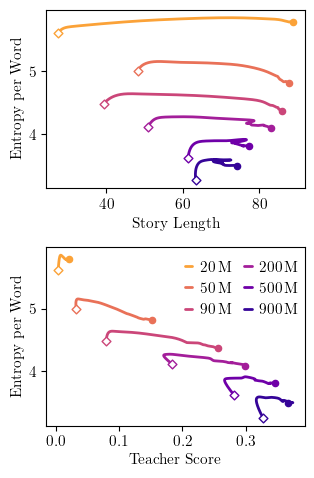

In [7]:
plt.show()
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 30
cmap = plt.get_cmap('tab10')
revision_numbers = sorted(
    batch_stats_dict.keys(),
    key=lambda x: int(str(x).replace('M', ''))
)
colors = [cmap(i) for i in range(len(revision_numbers))]

fraction=1.0/0.92
figsize = set_size(ncols=1,fraction=fraction, aspect_ratio=1.5)
fig, axes = plt.subplots(2, 1, figsize=figsize)

for color, revision in zip(ppo_colors, revision_numbers):
    df = batch_stats_dict[revision]
    student_len = df['student_len'].to_numpy()
    entropy_per_word = (df['entropy'] / df['student_len']).to_numpy()
    score = df['avg_teacher_reward'].to_numpy()

    # Smooth all axes
    student_len_smooth = gaussian_filter1d(student_len, sigma=sigma, mode='nearest')
    entropy_per_word_smooth = gaussian_filter1d(entropy_per_word, sigma=sigma, mode='nearest')
    score_smooth = gaussian_filter1d(score, sigma=sigma, mode='nearest')

    # Panel 1: Story Length vs Entropy per Word
    axes[0].plot(student_len_smooth, entropy_per_word_smooth, linewidth=2, color=color, label=rf"{revision}\,M")
    # Start marker ("x")
    axes[0].scatter(student_len_smooth[0], entropy_per_word_smooth[0], marker='D', facecolor='white', color=color, s=20, zorder=5)
    # End marker ("o")
    axes[0].scatter(student_len_smooth[-1], entropy_per_word_smooth[-1], marker='o', color=color, s=20, zorder=5)

    # Panel 2: Entropy per Word vs Teacher Score
    axes[1].plot(score_smooth, entropy_per_word_smooth, linewidth=2, color=color, label=rf"{revision}\,M")
    # Start marker ("x")
    axes[1].scatter(score_smooth[0], entropy_per_word_smooth[0], marker='D', facecolor='white', color=color, s=20, zorder=5)
    # End marker ("o")
    axes[1].scatter(score_smooth[-1], entropy_per_word_smooth[-1], marker='o', color=color, s=20, zorder=5)

# Labels and layout
axes[0].set_xlabel('Story Length')
axes[0].set_ylabel('Entropy per Word')
axes[1].set_xlabel('Teacher Score')
axes[1].set_ylabel('Entropy per Word')

axes[1].legend(frameon=False, loc='upper right', handlelength=0.5, handletextpad=0.5, ncols=2, columnspacing=0.8, bbox_to_anchor=[1.03,1])
plt.tight_layout()
#plt.savefig("figs/PPO_entropy_v_reward.pdf", bbox_inches='tight', pad_inches=0.02)
#check_pdf_size("figs/PPO_entropy_v_reward.pdf", figsize, fraction)
plt.show()

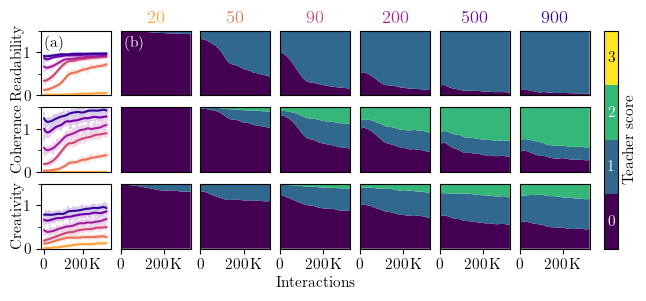

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter1d
import matplotlib.colors as mcolors
import re

score_list = ['Readability', 'Coherence', 'Creativity']
possible_values = [0, 1, 2, 3]
cmap = plt.get_cmap('viridis')
score_colors = [cmap(i / 3) for i in range(4)]

def revision_key(revision):
    m = re.match(r"(\d+)", str(revision))
    return int(m[1]) if m else float('inf')

revision_numbers = sorted(batch_stats_dict.keys(), key=revision_key)
n_models = len(revision_numbers)
n_scores = len(score_list)

fraction = 1.0 /  0.8847
main_grid_cols = n_models
total_cols = main_grid_cols + 1  # +1 for the left stacked score panels

figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.4)
fig = plt.figure(figsize=figsize)

# Gridspec: left column for scores, right for main grid
gs = GridSpec(n_scores, total_cols, width_ratios=[1] + [1]* main_grid_cols, wspace=0.14, hspace=0.18, figure=fig)

# Score axes (left column)
score_axes = [fig.add_subplot(gs[i, 0]) for i in range(n_scores)]
# Main grid panels
main_axes = np.array([[fig.add_subplot(gs[i, j+1]) for j in range(main_grid_cols)] for i in range(n_scores)])

sigma = 30
skip = 20
skip_unsmoothed = 1
lw = 1.5

# ----- stacked panels (left column) -----
for i, score in enumerate(score_list):
    ax = score_axes[i]
    for color, revision in zip(ppo_colors, revision_numbers):
        df = batch_stats_dict[revision]
        interaction_round = df['interaction_round'].values / 1e5
        y = df[f'avg_{score}'].values
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='nearest')
        pale = blend_with_white(mcolors.to_rgb(color), amount=0.8)
        ax.plot(interaction_round[::skip_unsmoothed], y[::skip_unsmoothed], alpha=1, color=pale, linewidth=1)
        ax.plot(interaction_round[::skip], y_smooth[::skip], color=color, linewidth=lw, label=rf"{revision}\,M", zorder=3)
    if i == 2:
        ax.set_xticks([0, 2])
        ax.set_xticklabels([0,r'200\,K'])
    else:
        ax.set_xticks([])
    ax.set_ylim(0, 1.23)
    ax.set_ylabel(score, labelpad=0)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['0', '1'])
    ax.set_yticks([0.5, 1.5], minor=True)
    #if i == len(score_list) - 1:
    #    ax.set_xlabel(r'Round ($\times 10^5$)')
#score_axes[0].legend(
#    frameon=False, handlelength=0.7, handletextpad=0.4, ncols=2,
#    loc='upper left', bbox_to_anchor=(0.0, 1.03)
#)

# ----- main grid (right of left column) -----
for j, revision in enumerate(revision_numbers):
    df = batch_stats_dict[revision]
    interaction_round = df['interaction_round'].values / 1e5
    for i, score in enumerate(score_list):
        ax = main_axes[i, j]
        fraction_cols = [f"{score}_count_{v}" for v in possible_values]
        score_fractions = df[fraction_cols].values.T
        smoothed_counts = np.array([
            gaussian_filter1d(row, sigma=sigma, mode='nearest')
            for row in score_fractions
        ])
        ax.stackplot(interaction_round[::skip], smoothed_counts[:, ::skip], colors=score_colors, alpha=1)
        ax.set_xlim(interaction_round.min(), interaction_round.max() - skip * batch_size / 1e5)
        ax.set_ylim(0, 1)
        if i == 0:
            ax.set_title(f"{revision}", color=ppo_colors[j])

for i in range(n_scores):
    for j in range(n_models):
        ax = main_axes[i, j]
        if i != 2:
            ax.set_xticks([])
        else:
            ax.set_xticks([0, 2])
            ax.set_xticklabels([0,r'200\,K'])
        ax.set_yticks([])
        if i == n_scores - 1 and j == 2:
            ax.set_xlabel(r"Interactions")
            #ax.xaxis.set_label_coords(-0.06, -0.35)

# ----- Colorbar to the right -----
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
boundaries = np.arange(-0.5, 4.5, 1)
sm = plt.cm.ScalarMappable(cmap=ListedColormap(score_colors), norm=plt.Normalize(vmin=0, vmax=3))
cbar = fig.colorbar(
    sm,
    cax=cbar_ax,
    boundaries=boundaries,
    ticks=possible_values,
    orientation='vertical',
)
cbar.set_label("Teacher score")
cbar.set_ticklabels([str(v) for v in possible_values])
cbar.set_ticks([])

# Annotate bins in colorbar
cbar_axis = cbar.ax
cbar_pos = cbar_axis.get_position()
ymin, ymax = cbar_axis.get_ylim()
bin_height = (ymax - ymin) / len(possible_values)
for i, val in enumerate(possible_values):
    y = ymin + (i + 0.5) * bin_height
    cbar_axis.text(
        0.55, y, str(val),
        ha='center', va='center',
        fontsize=fontsize, color = 'white' if i < 3 else 'black',
        transform=cbar_axis.transData
    )

# (a): to the left of the top score panel (Y-centered, X just outside axes)
score_axes[0].text(
    0.06, 0.92, "(a)", fontsize=fontsize, fontweight="bold",
    ha="left", va="top", transform=score_axes[0].transAxes
)

# (b): to the left of the top left main plot
main_axes[0,0].text(
    0.06, 0.92, "(b)", fontsize=fontsize, fontweight="bold",
    ha="left", va="top", transform=main_axes[0,0].transAxes, color='white'
)

#plt.savefig("figs/PPO_category.pdf", bbox_inches='tight', pad_inches=0.02)
#check_pdf_size("figs/PPO_category.pdf", figsize, fraction)
plt.show()

Rather show only mean (and story length?) for all models combined

Mention size of standard deviation per batch.

Bend happens due to KL divergence kicking in

## PPO before / after

Start/end values (mean ± std over 10 batches)


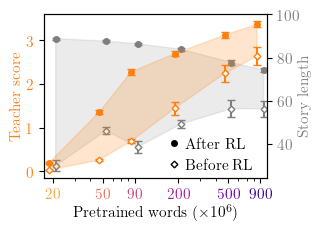

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

def average_edge(arr, n=10):
    arr = np.asarray(arr)
    if len(arr) < n:
        return (arr.mean(), arr.std()), (arr.mean(), arr.std())
    return (
        (arr[:n].mean(), arr[:n].std()),
        (arr[-n:].mean(), arr[-n:].std())
    )

revision_numbers = sorted(
    batch_stats_dict.keys(),
    key=lambda x: int(str(x).replace('M',''))
)
x_vals = np.array([float(str(r).replace('M','')) for r in revision_numbers])
offset = 0.12 * x_vals

# Collect means and stds for start/end (teacher, len)
n_avg = 10  # number of batches for averaging
markersize = 4

score_start_means, score_end_means, score_start_stds, score_end_stds = [], [], [], []
len_start_means, len_end_means, len_start_stds, len_end_stds = [], [], [], []

for rev in revision_numbers:
    df = batch_stats_dict[rev]
    scores = df['avg_score_sum'].values
    lens = df['student_len'].values
    (score_start_mean, score_start_std), (score_end_mean, score_end_std) = average_edge(scores, n=n_avg)
    (len_start_mean, len_start_std), (len_end_mean, len_end_std) = average_edge(lens, n=n_avg)
    score_start_means.append(score_start_mean)
    score_end_means.append(score_end_mean)
    score_start_stds.append(score_start_std)
    score_end_stds.append(score_end_std)
    len_start_means.append(len_start_mean)
    len_end_means.append(len_end_mean)
    len_start_stds.append(len_start_std)
    len_end_stds.append(len_end_std)


fraction = 1.0
figsize=set_size(ncols=1, fraction=fraction, aspect_ratio=0.7)
fig, ax1 = plt.subplots(figsize=figsize)
color1 = "tab:orange"
color2 = "tab:gray"
color1_pale = blend_with_white(mcolors.to_rgb(color1), amount=0.8)
color2_pale = blend_with_white(mcolors.to_rgb(color2), amount=0.8)

x_teacher = x_vals - offset/2
x_student = x_vals + offset/2

# Teacher (left)
for xi, y0, std0, y1, std1 in zip(x_teacher, score_start_means, score_start_stds, score_end_means, score_end_stds):
    #ax1.plot([xi, xi], [y0, y1], color=color1, lw=2, alpha=1)
    ax1.errorbar(xi, y0, yerr=std0, fmt='D', mfc='White', mec=color1, mew=1, color=color1, capsize=3, ms=0.85*markersize, zorder=3)
    ax1.errorbar(xi, y1, yerr=std1, fmt='o', mfc=color1, mec=color1, mew=1, color=color1, capsize=3, ms=markersize, zorder=4)

x_band = np.concatenate([x_teacher, x_teacher[::-1]])
y_band = np.concatenate([score_start_means, score_end_means[::-1]])

ax1.fill(
    x_band,
    y_band,
    color=color1,
    alpha=0.2,
    zorder=0,
    linestyle='-'
)

ax1.set_ylabel("Teacher score", color=color1, labelpad=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')
ax1.set_xlabel(r"Pretrained words ($\times 10^6$)", labelpad=2)
ax1.set_xticks(x_vals)
ax1.set_xticklabels(revision_numbers)
for ticklabel, color in zip(ax1.get_xticklabels(), ppo_colors):
    ticklabel.set_color(color)
ax1.set_xlim(left=17)
ax1.set_ylim(top=3.6)

# Student length (right)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
for xi, y0, std0, y1, std1 in zip(x_student, len_start_means, len_start_stds, len_end_means, len_end_stds):
    #ax2.plot([xi, xi], [y0, y1], color=color2, lw=2, alpha=1)
    ax2.errorbar(xi, y0, yerr=std0, fmt='D', mfc='White', mec=color2, mew=1, color=color2, capsize=3, ms=0.85*markersize, zorder=1)
    ax2.errorbar(xi, y1, yerr=std1, fmt='o', mfc=color2, mec=color2, mew=1, color=color2, capsize=3, ms=markersize, zorder=1)

x_band2 = np.concatenate([x_student, x_student[::-1]])
y_band2 = np.concatenate([len_start_means, len_end_means[::-1]])

ax2.fill(
    x_band2,
    y_band2,
    color=color2,
    alpha=0.15,
    zorder=0,
    linestyle='-'
)

ax2.set_ylabel("Story length", color=color2, labelpad=-1.5)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(top=100)

start_handle = mlines.Line2D([], [], color='black', marker='D', mfc='White', linestyle='None', ms=0.85*markersize, label='Start')
finish_handle = mlines.Line2D([], [], color='black', marker='o', mfc='black', linestyle='None', ms=markersize, label='Finish')

ax1.legend(
    [finish_handle, start_handle],
    ['After RL', 'Before RL'],
    loc='lower right',
    frameon=False,
    handletextpad=0.5,
    handlelength=0.5,
    bbox_to_anchor=(1, -0.05),
)

print(f"Start/end values (mean ± std over {n_avg} batches)")
plt.tight_layout(pad=0)
#plt.savefig("figs/PPO_start_finish.pdf")
#check_pdf_size("figs/default_tokenizer/PPO_start_finish.pdf", figsize, fraction)
plt.show()

In [12]:
score_start_means

[np.float64(0.03222222222222222),
 np.float64(0.25805555555555554),
 np.float64(0.6980555555555557),
 np.float64(1.4480555555555554),
 np.float64(2.2475),
 np.float64(2.6408333333333336)]

In [13]:
score_end_means

[np.float64(0.1963888888888889),
 np.float64(1.3558333333333332),
 np.float64(2.279722222222222),
 np.float64(2.7),
 np.float64(3.1249999999999996),
 np.float64(3.368055555555555)]

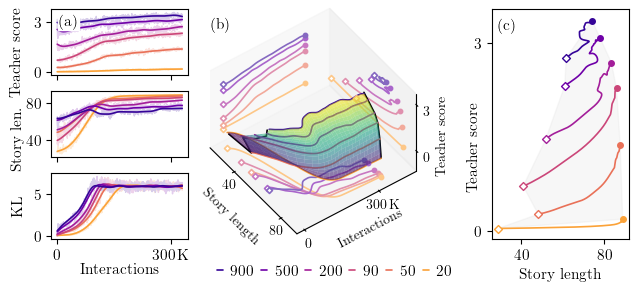

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors

#--- Helper as above (Define blend_with_white, fields, score_list, revision_numbers, ppo_colors, batch_stats_dict etc.) ---

fraction = 1.0 / 0.84
figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.4)
fig = plt.figure(figsize=figsize)

# 3 columns: left (stacked), center (3D), right (score-v-length)
gs = GridSpec(3, 3, width_ratios=[0.5, 0.9, 0.5], height_ratios=[1, 1, 1], wspace=0.16, hspace=0.25, figure=fig)

# Panel A: stacked 3 left plots (fields)
left_axes = [fig.add_subplot(gs[i, 0]) for i in range(3)]  # vertical stack

# Panel B: 3D plot (center, spans all 3 rows)
center_ax = fig.add_subplot(gs[:, 1], projection='3d', proj_type='ortho')

# Panel C: score-vs-length plot (right, middle row)
right_ax = fig.add_subplot(gs[:, 2])

#--- LEFT: stacked fields plot (your second code block, adapted) ---
fields = [
    ('avg_score_sum', r'Teacher score'),
    ('student_len', r'Story len.'),
    ('kl', 'KL'),
]
skip = 3
sigma = 30  # Smoothing std
markersize_3D = 3
markersize = 4
lw = 1.2

for idx, (fieldname, fieldlabel) in enumerate(fields):
    ax = left_axes[idx]
    for color, revision in zip(ppo_colors, revision_numbers):
        df = batch_stats_dict[revision]
        interaction_rounds = df['interaction_round'].values / 1e5
        y = df[fieldname].values
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='nearest')

        pale = blend_with_white(mcolors.to_rgb(color), amount=0.8)
        ax.plot(interaction_rounds, y, color=pale, linewidth=1)
        ax.plot(interaction_rounds, y_smooth, color=color, linewidth=lw, label=rf"{revision}\,M", zorder=3)

    ax.set_xticks([0,3])
    if idx == 1:
        ax.set_yticks([40,80])
    ax.set_ylabel(fieldlabel, labelpad=6)
    if idx == 0:
        ax.yaxis.set_label_coords(-0.20, 0.34)
    if idx == 0:
        ax.set_yticks([0,3])
    if idx < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(r'Interactions', labelpad=1)
        ax.set_xticklabels([0,r'300\,K'])
    if idx == 1:
        ax.yaxis.set_label_coords(-0.20, 0.28)


#ax.text(
#    0.99, -0.25, r"$\times 10^5$",  # (x, y) = near the right end, below axis
#    ha="right", va="center",
#    transform=ax.transAxes,
#    fontsize=11
#)

#--- CENTER: your 3D plot (central panel, keep code) ---
all_rounds = np.concatenate([df['interaction_round'].values / 1e5 for df in batch_stats_dict.values()])
round_grid = np.linspace(all_rounds.min(), all_rounds.max(), 130)
student_grid, score_grid = [], []
for revision in revision_numbers:
    df = batch_stats_dict[revision]
    rounds = df['interaction_round'].values / 1e5
    student = gaussian_filter1d(df['student_len'].values, sigma=sigma, mode='nearest')
    score = gaussian_filter1d(df['avg_score_sum'].values, sigma=sigma, mode='nearest')
    st_interp = interp1d(rounds, student, bounds_error=False, fill_value=np.nan)
    sc_interp = interp1d(rounds, score, bounds_error=False, fill_value=np.nan)
    student_grid.append(st_interp(round_grid))
    score_grid.append(sc_interp(round_grid))
student_grid = np.array(student_grid)
score_grid = np.array(score_grid)
ROUNDS = np.tile(round_grid, (len(revision_numbers), 1))
n_models, n_prompts = student_grid.shape

dense_model_axis = np.linspace(0, n_models-1, 40)
dense_student, dense_score = [], []
for pi in range(n_prompts):
    student_across_models = student_grid[:, pi]
    score_across_models = score_grid[:, pi]
    f_student = interp1d(np.arange(n_models), student_across_models, kind="linear")
    f_score = interp1d(np.arange(n_models), score_across_models, kind="linear")
    dense_student.append(f_student(dense_model_axis))
    dense_score.append(f_score(dense_model_axis))
dense_student = np.array(dense_student).T
dense_score = np.array(dense_score).T
dense_round = np.tile(round_grid, (len(dense_model_axis), 1))

surf = center_ax.plot_surface(
    dense_student,       # x
    dense_round,        # y
    dense_score,         # z
    cmap='viridis',
    alpha=0.6,
    linewidth=0.5,
    ccount=30,
    rcount=30,
    edgecolor='None',
    antialiased=True,
    zorder=-1,
)
proj_score  = -1
proj_rounds  = 4.2
proj_length = 24
alpha_proj = 1.0
alpha_orig = 1.0
for student_curve, score_curve, color, rev_lab in zip(student_grid, score_grid, ppo_colors, revision_numbers):
    pale = blend_with_white(mcolors.to_rgb(color), amount=0.4)
    center_ax.plot(student_curve, round_grid, score_curve, color=color, lw=lw, label=rf"{rev_lab}", linestyle='-')
    # projections and extra markers as in your code
    center_ax.scatter(proj_length + 0 * student_curve[0], round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(proj_length + 0 * student_curve[-1], round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[0], proj_rounds + 0 * round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[-1], proj_rounds + 0 * round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[0], round_grid[0], proj_score + 0 * score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.scatter(student_curve[-1], round_grid[-1], proj_score + 0 * score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.plot(proj_length + 0 * student_curve, round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.plot(student_curve, proj_rounds + 0 * round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
    center_ax.plot(student_curve, round_grid, proj_score + 0 * score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)

center_ax.set_xlabel("Story length", labelpad=-5, fontsize=fontsize - 1)
center_ax.set_ylabel(r"Interactions", labelpad=-7, fontsize=fontsize - 1)
center_ax.set_zlabel("Teacher score", labelpad=-10, fontsize=fontsize - 1)
#scalefactor_label = r'$\times 10^5$'
#center_ax.text(
#    20, 50, -30, scalefactor_label,
#    zdir='y',
#    transform=center_ax.transAxes,
#    va="center", ha="right", fontsize=fontsize - 1
#)
center_ax.set_xticks([40,80])
center_ax.set_yticks([0,3])
center_ax.set_yticklabels([0,r'300\,K'])
center_ax.set_zticks([0,3])
for tick_label in (center_ax.get_xticklabels() +
                   center_ax.get_yticklabels() +
                   center_ax.get_zticklabels()):
    tick_label.set_fontsize(fontsize - 1)
tick_pad = -4
center_ax.xaxis.set_tick_params(pad=tick_pad)
center_ax.yaxis.set_tick_params(pad=tick_pad)
center_ax.zaxis.set_tick_params(pad=tick_pad)
handles, labels = center_ax.get_legend_handles_labels()
#center_ax.legend(handles[::-1], labels[::-1], frameon=False, handlelength=0.5, handletextpad=0.5, loc='upper left', bbox_to_anchor=(0.75,1.0), ncols=2)
center_ax.grid(False)
center_ax.view_init(elev=46, azim=-36, roll=0)

# Shift center axis to left
pos = center_ax.get_position()
new_pos = [pos.x0 - 0.04, pos.y0, pos.width, pos.height]  # shift left by 0.04 (fraction of fig)
center_ax.set_position(new_pos)

#--- RIGHT: score vs length panel (your last code block, on right column, middle row only) ---
# [You may also want: right_ax = fig.add_subplot(gs[1, 2])]
student_len_smooth_start = []
student_len_smooth_end = []
score_smooth_start = []
score_smooth_end = []

for color, revision in zip(ppo_colors, revision_numbers):
    df = batch_stats_dict[revision]
    story_len = df['student_len'].to_numpy()
    score = df['avg_score_sum'].to_numpy()

    score_smooth = gaussian_filter1d(score, sigma=sigma, mode='mirror')
    student_len_smooth = gaussian_filter1d(story_len, sigma=sigma, mode='mirror')

    student_len_smooth_start.append(student_len_smooth[0])
    student_len_smooth_end.append(student_len_smooth[-1])
    score_smooth_start.append(score_smooth[0])
    score_smooth_end.append(score_smooth[-1])

    right_ax.plot(student_len_smooth, score_smooth, linewidth=lw, color=color, label=rf"{revision}")
    right_ax.scatter(student_len_smooth[0], score_smooth[0], marker='D', color=color, facecolor='white', s=markersize**2, zorder=5)
    right_ax.scatter(student_len_smooth[-1], score_smooth[-1], marker='o', color=color, facecolor=color, s=markersize**2, zorder=5)

right_ax.fill(
    np.concatenate([student_len_smooth_start, student_len_smooth_end[::-1]]),
    np.concatenate([score_smooth_start, score_smooth_end[::-1]]),
    color=[0.8,0.8,0.8],
    alpha=0.15,
    zorder=0,
    linestyle='-'
)
#right_ax.plot(student_len_smooth_start, score_smooth_start, linewidth=lw, color="black", zorder=0)
#right_ax.plot(student_len_smooth_end, score_smooth_end, linewidth=lw, color="black", zorder=0)
right_ax.set_xticks([40,80])
right_ax.set_yticks([0,3])
right_ax.set_xlabel('Story length')
right_ax.set_ylabel('Teacher score', labelpad=0)
right_ax.yaxis.set_label_coords(-0.08, 0.4)
handles, labels = right_ax.get_legend_handles_labels()
right_ax.legend(handles[::-1], labels[::-1], frameon=False, ncols=6, columnspacing=0.5, handlelength=0.4, handletextpad=0.5, loc='upper left', bbox_to_anchor=(-2.1, -0.05))


center_ax.plot(student_len_smooth_start, np.min(round_grid) * np.ones(len(score_smooth_start)) , score_smooth_start, linewidth=lw, color="black", zorder=-2)
center_ax.plot(student_len_smooth_end, np.max(round_grid) * np.ones(len(score_smooth_end)) , score_smooth_end, linewidth=lw, color="black", zorder=-2)


panel_labels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(left_axes):
    if i == 0:
        ax.text(
            0.06, 0.92, panel_labels[i], fontsize=fontsize, fontweight="bold",
            ha="left", va="top", transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
        )

# (b): to the left of the top left main plot
center_ax.text(
    90, 4, 80, "(b)", fontsize=fontsize, fontweight="bold",
    ha="left", va="top", transform=center_ax.transAxes, color='black'
)

right_ax.text(
    0.05, 0.96, '(c)', fontsize=fontsize, fontweight='bold',
    ha='left', va='top', transform=right_ax.transAxes,
    color='black'
)

#plt.tight_layout()
#plt.savefig("figs/PPO_dynamics.pdf", bbox_inches='tight', pad_inches=0.03)
#check_pdf_size("figs/PPO_dynamics.pdf", figsize, fraction)
plt.show()

In [15]:
score_smooth_end

[np.float64(0.18644728027410995),
 np.float64(1.3715940626223502),
 np.float64(2.2776652303392666),
 np.float64(2.6908890618088916),
 np.float64(3.091025032093208),
 np.float64(3.3643433866577754)]

In [16]:
score_smooth_start

[np.float64(0.03583388838995941),
 np.float64(0.26492491412584623),
 np.float64(0.7144909112118273),
 np.float64(1.464195282418415),
 np.float64(2.3212075287589045),
 np.float64(2.765106337950397)]

#### Stereogram

=== PDF actual area ===:
  706.31pt x 327.42pt  ||  9.8098in x 4.5475in
=== Your target figsize from set_size, corrected for fraction:
  536.91pt x 214.76pt  ||  7.4571in x 2.9828in
=== Ratio (actual/target):
  width: 131.55%,  height: 152.45%


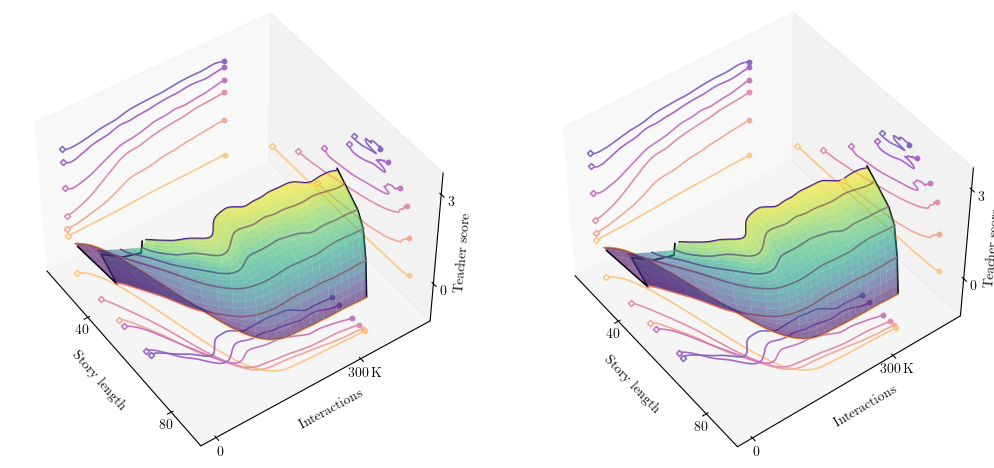

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import numpy as np

# === Helper: Set your stereo viewpoint deltas ===
stereo_delta_deg = 2   # difference in azimuth between left/right
azim_center = -36       # Azimuth
elev_angle = 46         # Elevation

# === Build stereo figure and axes ===
fraction = 1.0 / 1
fig_width = 2 * set_size(ncols=2, fraction=fraction, aspect_ratio=1)[0]
fig_height = set_size(ncols=2, fraction=fraction, aspect_ratio=1)[1]
fig, axes = plt.subplots(
    1, 2, subplot_kw={"projection": "3d"},
    figsize=(fig_width, fig_height)
)

for i, ax in enumerate(axes):
    # Set perspective for stereo effect
    azim = azim_center + (stereo_delta_deg / 2 if i == 0 else -stereo_delta_deg / 2)
    ax.view_init(elev=elev_angle, azim=azim, roll=0)

    # --- Copy code for drawing your 3D data as in the middle panel above ---
    surf = ax.plot_surface(
        dense_student,       # x
        dense_round,         # y
        dense_score,         # z
        cmap='viridis',
        alpha=0.6,
        linewidth=0.5,
        ccount=30,
        rcount=30,
        edgecolor='None',
        antialiased=True,
        zorder=-1,
    )

    # Plot 3D trajectories, projections, etc.
    for student_curve, score_curve, color, rev_lab in zip(student_grid, score_grid, ppo_colors, revision_numbers):
        pale = blend_with_white(mcolors.to_rgb(color), amount=0.4)
        ax.plot(student_curve, round_grid, score_curve, color=color, lw=lw, label=rf"{rev_lab}", linestyle='-')
        # Projections and extra markers as in your original code
        ax.scatter(proj_length + 0 * student_curve[0], round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(proj_length + 0 * student_curve[-1], round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[0], proj_rounds + 0 * round_grid[0], score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[-1], proj_rounds + 0 * round_grid[-1], score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[0], round_grid[0], proj_score + 0 * score_curve[0], marker='D', color=pale, s=markersize_3D**2, facecolor='white', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.scatter(student_curve[-1], round_grid[-1], proj_score + 0 * score_curve[-1], marker='o', color=pale, s=markersize_3D**2, facecolor=pale, alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.plot(proj_length + 0 * student_curve, round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.plot(student_curve, proj_rounds + 0 * round_grid,  score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
        ax.plot(student_curve, round_grid, proj_score + 0 * score_curve, color=pale, linestyle='-', alpha=alpha_proj, zorder=-3, linewidth=lw)
    # Add projections at the base/edge
    ax.plot(student_len_smooth_start, np.min(round_grid) * np.ones(len(score_smooth_start)), score_smooth_start, linewidth=lw, color="black", zorder=-2)
    ax.plot(student_len_smooth_end, np.max(round_grid) * np.ones(len(score_smooth_end)), score_smooth_end, linewidth=lw, color="black", zorder=-2)

    # Style
    ax.set_xlabel("Story length", labelpad=-5, fontsize=fontsize - 1)
    ax.set_ylabel(r"Interactions", labelpad=-7, fontsize=fontsize - 1)
    ax.set_zlabel("Teacher score", labelpad=-10, fontsize=fontsize - 1)
    ax.set_xticks([40, 80])
    ax.set_yticks([0, 3])
    ax.set_yticklabels([0, r'300\,K'])
    ax.set_zticks([0, 3])
    for tick_label in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
        tick_label.set_fontsize(fontsize - 1)
    tick_pad = -4
    ax.xaxis.set_tick_params(pad=tick_pad)
    ax.yaxis.set_tick_params(pad=tick_pad)
    ax.zaxis.set_tick_params(pad=tick_pad)
    ax.grid(False)

#plt.tight_layout()
plt.savefig("figs/PPO_dynamics_stereo.pdf", bbox_inches='tight', pad_inches=0.03)
check_pdf_size("figs/PPO_dynamics_stereo.pdf", figsize, fraction)
plt.show()

## Visualization

## Final evals

In [30]:
from pathlib import Path
import pandas as pd

# === Metric rename mapping ===
METRIC_RENAME = {
    "BLIMP": "BLiMP",
    "SUPPLEMENT": "Suppl.",
    "ENTITY": "ET",
    "EWOK": "EWOK",
    "WUG_ADJ": "WUG Adj",
    "WUG_PAST": "WUG Past",
    "COMPS": "COMPS",
    "READING (SPR)": "SPR",
    "READING (ET)": "Eye-T",
    "GLUE": "GLUE",
    "AOA": "AoA"
}

BASE_DIR = Path("eval/results")

# === Models to plot ===
MODELS = {
    "1000M-pre": {
        "path": "babylm-baseline-100m-gpt2/eval_main.csv",
        "color": "black",
        "zorder": 3
    },
    "SimPO": {
        "path": "babylm-interaction-baseline-simpo/eval_main.csv",
        "color": "tab:gray",
        "zorder": 3
    },
    "900M-pre": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_chck_900M.csv",
        "color": "tab:blue",
        "zorder": 2
    },
    "900M-RL": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_main.csv",
        "color": "tab:red",
        "zorder": 4
    }
}

def load_eval_csvs(models: dict, base_dir: Path) -> pd.DataFrame:
    rows = []
    for model_name, style in models.items():
        csv_path = base_dir / style["path"]
        if not csv_path.exists():
            raise FileNotFoundError(f"Missing eval CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        for _, row in df.iterrows():
            metric_disp = METRIC_RENAME.get(row["Metric"], row["Metric"])
            rows.append({
                "Metric": metric_disp,
                "Score": row["Score"],
                "Model": model_name,
                "Color": style["color"],
                "Zorder": style["zorder"]
            })
    return pd.DataFrame(rows)

df_eval = load_eval_csvs(MODELS, BASE_DIR)
df_eval.head()

,Metric,Score,Model,Color,Zorder
0,BLiMP,74.880924,1000M-pre,black,3
1,Suppl.,63.315881,1000M-pre,black,3
2,EWOK,51.671384,1000M-pre,black,3
3,ET,31.509803,1000M-pre,black,3
4,WUG Adj,50.238826,1000M-pre,black,3


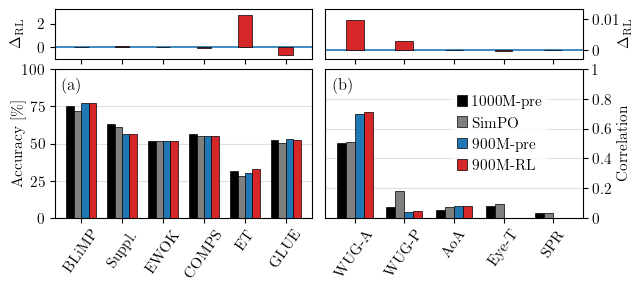

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

# Metric rename mapping
METRIC_RENAME = {
    "BLIMP": "BLiMP",
    "SUPPLEMENT": "Suppl.",
    "ENTITY": "ET",
    "EWOK": "EWOK",
    "WUG_ADJ": "WUG-A",
    "WUG_PAST": "WUG-P",
    "COMPS": "COMPS",
    "READING (SPR)": "SPR",
    "READING (ET)": "Eye-T",
    "GLUE": "GLUE",
    "AOA": "AoA"
}

BASE_DIR = Path("eval/results")

MODELS = {
    "1000M-pre": {
        "path": "babylm-baseline-100m-gpt2/eval_main.csv",
        "color": "black", "zorder": 3
    },
    "SimPO": {
        "path": "babylm-interaction-baseline-simpo/eval_main.csv",
        "color": "tab:gray", "zorder": 3
    },
    "900M-pre": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_chck_900M.csv",
        "color": "tab:blue", "zorder": 2
    },
    "900M-RL": {
        "path": "blm-gpt2s-90M-s42_901M-s42_submission/eval_main.csv",
        "color": "tab:red", "zorder": 4
    }
}

baseline_color = MODELS['900M-pre']["color"]

def load_eval_csvs(models, base_dir):
    rows = []
    for model_name, style in models.items():
        csv_path = base_dir / style["path"]
        if not csv_path.exists():
            raise FileNotFoundError(f"Missing eval CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        for _, row in df.iterrows():
            metric_disp = METRIC_RENAME.get(row["Metric"], row["Metric"])
            rows.append({
                "Metric": metric_disp,
                "Score": row["Score"],
                "Model": model_name,
                "Color": style["color"],
                "Zorder": style["zorder"]
            })
    return pd.DataFrame(rows)

df_eval = load_eval_csvs(MODELS, BASE_DIR)

# Metric sets
ACC_METRICS = ["BLiMP", "Suppl.", "EWOK", "COMPS", "ET", "GLUE"]
NONACC_METRICS = ["WUG-A", "WUG-P", "AoA", "Eye-T", "SPR"]

acc_order = ACC_METRICS
nonacc_order = NONACC_METRICS
model_names_in_order = list(MODELS.keys())
n_models = len(model_names_in_order)
width_bottom = 0.18        # keep existing for bottom row
width_top = width_bottom * 2   # ~30% slimmer for top row
edgewidth = 0.5
edgecolor = 'black'

# --- Compute differences (900M-RL − 900M-pre) ---
diffs_acc = []
for metric in acc_order:
    rl = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-RL"), "Score"].values[0]
    pre = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-pre"), "Score"].values[0]
    diffs_acc.append(rl - pre)

diffs_nonacc = []
for metric in nonacc_order:
    rl = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-RL"), "Score"].values[0]
    pre = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == "900M-pre"), "Score"].values[0]
    # Convert correlation type from ×100 back to 0–1
    if metric in ["WUG-A", "WUG-P", "Eye-T", "SPR"]:
        rl /= 100.0
        pre /= 100.0
    diffs_nonacc.append(rl - pre)

# --- Figure with 2×2 layout, top row smaller ---
fraction = 1.0 / 0.9569
figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.5)  # a bit taller for 2 rows
fig, axes = plt.subplots(
    2, 2, figsize=figsize, sharex='col',
    gridspec_kw={"height_ratios": [1, 3]}
)

ax_diff_left, ax_diff_right = axes[0]
ax_left, ax_right = axes[1]

# --- TOP LEFT: Accuracy differences ---
ax_diff_left.bar(np.arange(len(acc_order)), diffs_acc, color="tab:red", edgecolor=edgecolor, linewidth=edgewidth, width=width_top)
ax_diff_left.axhline(0, color=baseline_color, lw=1.2, zorder=0)
ax_diff_left.set_ylabel(r"$\Delta_{\mathrm{RL}}$", labelpad=10)
#ax_diff_left.grid(axis='y', linestyle='-', alpha=0.4)
ax_diff_left.set_xticks([])
ax_diff_left.set_xticklabels([])
ax_diff_left.set_ylim([-1,3.2]),
ax_diff_left.set_yticks([0,2])
ax_diff_left.set_yticklabels([0,2])

# --- TOP RIGHT: Non-Accuracy differences ---
ax_diff_right.bar(np.arange(len(nonacc_order)), diffs_nonacc, color="tab:red", edgecolor=edgecolor, linewidth=edgewidth, width=width_top)
ax_diff_right.axhline(0, color=baseline_color, lw=1.2, zorder=0)
ax_diff_right.set_ylabel(r"$\Delta_{\mathrm{RL}}$", labelpad=-1)
##ax_diff_right.grid(axis='y', linestyle='-', alpha=0.4)
ax_diff_right.set_xticks([])
ax_diff_right.set_xticklabels([])
ax_diff_right.set_ylim([-0.003,0.013]),
ax_diff_right.set_yticks([0,0.01])
ax_diff_right.set_yticklabels([0,0.01])

# --- BOTTOM LEFT: Accuracy results ---
for i, model in enumerate(model_names_in_order):
    col = MODELS[model]["color"]; z = MODELS[model]["zorder"]
    yvals = [
        df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == model), "Score"].values[0]
        for metric in acc_order
    ]
    xpos = np.arange(len(acc_order)) + i * width_bottom - (width_bottom * n_models / 2) + width_bottom / 2
    ax_left.bar(xpos, yvals, width=width_bottom, color=col, edgecolor=edgecolor, linewidth=edgewidth, zorder=z, label=model)

ax_left.set_ylabel(r"Accuracy [\%]", labelpad=-3)
ax_left.set_ylim(0, 100)
ax_left.grid(axis='y', linestyle='-', alpha=0.4)
ax_left.set_xticks(np.arange(len(acc_order)))
ax_left.set_xticklabels(acc_order, rotation=55, ha="center")

# --- BOTTOM RIGHT: Non-Accuracy results ---
for i, model in enumerate(model_names_in_order):
    col = MODELS[model]["color"]; z = MODELS[model]["zorder"]
    yvals = []
    for metric in nonacc_order:
        val = df_eval.loc[(df_eval["Metric"] == metric) & (df_eval["Model"] == model), "Score"].values[0]
        if metric in ["WUG-A", "WUG-P", "Eye-T", "SPR"]:
            val /= 100.0
        yvals.append(val)
    xpos = np.arange(len(nonacc_order)) + i * width_bottom - (width_bottom * n_models / 2) + width_bottom / 2
    ax_right.bar(xpos, yvals, width=width_bottom, color=col, edgecolor=edgecolor, linewidth=edgewidth, zorder=z)

ax_right.set_ylabel(r"Correlation")
ax_right.set_ylim(0, 1)
ax_right.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax_right.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax_right.grid(axis='y', linestyle='-', alpha=0.4)
ax_right.set_xticks(np.arange(len(nonacc_order)))
ax_right.set_xticklabels(nonacc_order, rotation=55, ha="center")


ax_diff_right.yaxis.set_label_position("right")
ax_diff_right.yaxis.tick_right()

ax_right.yaxis.set_label_position("right")
ax_right.yaxis.tick_right()

# --- Legend ---
legend_handles = [
    plt.Rectangle((0,0), 1, 1, facecolor=style["color"], edgecolor='black', lw=edgewidth, label=name)
    for name, style in MODELS.items()
]
fig.legend(
    handles=legend_handles,
    labels=MODELS.keys(),  # model names in order
    loc='center right', ncol=1, bbox_to_anchor=(0.86, 0.5),
    columnspacing=1, frameon=True, edgecolor='None',
    borderpad=0.4, handlelength=0.7, handletextpad=0.3
)

# Add subplot panel labels
ax_left.text(0.03, 0.95, "(a)", transform=ax_left.transAxes,
             ha='left', va='top', fontsize=12, fontweight='bold')
ax_right.text(0.03, 0.95, "(b)", transform=ax_right.transAxes,
              ha='left', va='top', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.1, wspace=0.05)
#plt.savefig("figs/blm_eval.pdf", bbox_inches='tight', pad_inches=0.03)
#check_pdf_size("figs/blm_eval.pdf", figsize, fraction)
plt.show()

# Archive / Legacy code

## Get final evals

In [122]:
import os
import re
import pandas as pd

# =================== CONFIGURATION ===================

# List the zero-shot/causal tasks/subtasks to extract from each run
ZERO_SHOT_CASUAL_TASKS = {
    "blimp": {
        "scenarios": ["blimp_filtered", "supplement_filtered"],
        "filename": "best_temperature_report.txt"
    },
    "entity_tracking": {
        "scenarios": ["entity_tracking"],
        "filename": "best_temperature_report.txt"
    },
    "ewok": {
        "scenarios": ["ewok_filtered"],
        "filename": "best_temperature_report.txt"
    },
    "reading": {
        "scenarios": [],
        "filename": "report.txt"
    },
    "wug": {
        "scenarios": ["wug_adj_nominalization"],
        "filename": "best_temperature_report.txt"
    }
}

# For the final finetune tasks
FINETUNE_TASKS = ["boolq", "mnli", "mrpc", "multirc", "qqp", "rte"]

# =============== EXTRACTION FUNCTIONS ================

def extract_scalar_from_file(filepath, pattern, cast_type=float):
    """Utility to extract the first occurrence of a number after a specific pattern."""
    try:
        with open(filepath, "r") as f:
            text = f.read()
        m = re.search(pattern, text)
        if m:
            return cast_type(m.group(1))
    except Exception as e:
        print(f"[WARN] Failed to extract scalar from {filepath}: {e}")
    return None

def extract_all_numbered_lines(content, prefix):
    """Extract lines in the format: [metric]: [number] from report blocks."""
    scores = {}
    # Accept both : and :\s+ floats
    regex = re.compile(rf"^\s*([\w/\-\. ]+):\s*([-\d\.]+)", re.MULTILINE)
    for match in regex.finditer(content):
        name = match.group(1).strip().replace(" ", "_").replace("/", "_").replace("-", "_")
        try:
            value = float(match.group(2))
        except Exception:
            continue
        # Prefix to avoid collisions across schemes
        scores[f"{prefix}_{name}"] = value
    return scores

def extract_report_block(content, block_name, prefix):
    """
    Extract lines like 'metric: value' under '### BLOCK_NAME ACCURACY',
    where metric starts with alpha, not a float.
    """
    block_start = f"### {block_name.upper()} ACCURACY"
    idx = content.find(block_start)
    if idx == -1:
        return {}
    content = content[idx+len(block_start):]
    next_block = re.search(r"\n### ", content)
    block = content[:next_block.start()] if next_block else content

    scores = {}
    # Only keep metrics where name starts with a letter
    regex = re.compile(r"^\s*([a-zA-Z][\w/\-_ ]*):\s*([-\d\.]+)", re.MULTILINE)
    for match in regex.finditer(block):
        name = match.group(1).strip().replace(" ", "_").replace("/", "_").replace("-", "_")
        value = float(match.group(2))
        scores[f"{prefix}_{name}"] = value
    return scores

def extract_zero_shot_file(filepath, task, scenario=None):
    """Extract all metrics from a zero_shot/causal output file."""
    try:
        with open(filepath,"r") as f:
            content = f.read()
    except Exception as e:
        print(f"[WARN] Could not open {filepath}: {e}")
        return {}
    results = {}

    if task in ["blimp", "entity_tracking", "ewok", "wug"]:
        temp = re.search(r"TEMPERATURE:\s*([-\d\.]+)", content)
        if temp:
            results["temperature"] = float(temp.group(1))
        avg_acc = re.search(r"AVERAGE ACCURACY[\n:]*\s*([-\d\.]+)", content)
        if avg_acc:
            # Only divide by 100 if it's in percentage (if > 1.5), else it's 0...1
            val = float(avg_acc.group(1))
            results["average_accuracy"] = val if val <= 1.2 else val / 100
        for block in ["FIELD", "UID", "CONTEXT_TYPE", "CONTEXT_CONTRAST", "TARGET_CONTRAST", "LINGUISTICS_TERM"]:
            results.update(extract_report_block(content, block, f"{block.lower()}"))
    elif task == "reading":
        # For reading, standard
        eye = re.search(r"EYE TRACKING SCORE:\s*([-\d\.]+)", content)
        if eye:
            results["eye_tracking_score"] = float(eye.group(1))
        spr = re.search(r"SELF-PACED READING SCORE:\s*([-\d\.]+)", content)
        if spr:
            results["selfpaced_reading_score"] = float(spr.group(1))
    return results

def extract_finetune_file(filepath):
    """Extract accuracy from a finetune results.txt file."""
    # Should be a line like: accuracy: 0.7387...
    return {"accuracy": extract_scalar_from_file(filepath,r"accuracy:\s*([-\d\.]+)")}

# =============== MAIN FUNCTION ======================

def extract_babylm_final(models_and_checkpoints, base_results_dir="results", verbose=True):
    """Given list of [model_dir, checkpoint] pairs, extract all relevant metrics."""
    rows = []
    for model_dir, checkpoint in models_and_checkpoints:
        base_cp_dir = os.path.join(base_results_dir, model_dir, checkpoint)
        if not os.path.exists(base_cp_dir):
            print(f"[ERROR] Model checkpoint dir missing: {base_cp_dir}")
            continue
        model_name = model_dir
        revision = checkpoint

        if verbose:
            print(f"\n[INFO] Processing: {model_dir} / {checkpoint}")

        # --- Finetune tasks ---
        for task in FINETUNE_TASKS:
            finetune_dir = os.path.join(base_cp_dir, "finetune", task)
            result_file = os.path.join(finetune_dir, "results.txt")
            if not os.path.exists(result_file):
                print(f"[WARN] Finetune task missing: {result_file}")
                continue
            results = extract_finetune_file(result_file)
            row = {
                "model_name": model_name,
                "revision": revision,
                "task_type": "finetune",
                "task": task,
            }
            row.update(results)
            rows.append(row)

        # --- Zero-shot tasks ---
        for task, task_info in ZERO_SHOT_CASUAL_TASKS.items():
            if task == "reading":
                # No scenario
                path = os.path.join(base_cp_dir, "zero_shot", "causal", task, task_info["filename"])
                if not os.path.exists(path):
                    print(f"[WARN] Reading task file missing: {path}")
                    continue
                results = extract_zero_shot_file(path, task)
                row = {
                    "model_name": model_name,
                    "revision": revision,
                    "task_type": "zero_shot",
                    "task": task
                }
                row.update(results)
                rows.append(row)
            else:
                for scenario in task_info["scenarios"]:
                    # E.g., blimp/blimp_filtered/best_temperature_report.txt
                    subdir = os.path.join(base_cp_dir, "zero_shot", "causal", task, scenario)
                    path = os.path.join(subdir, task_info["filename"])
                    if not os.path.exists(path):
                        print(f"[WARN] Zero-shot scenario missing: {path}")
                        continue
                    results = extract_zero_shot_file(path, task, scenario)
                    row = {
                        "model_name": model_name,
                        "revision": revision,
                        "task_type": "zero_shot",
                        "task": f"{task}/{scenario}"  # e.g. blimp/blimp_filtered
                    }
                    row.update(results)
                    rows.append(row)
    df = pd.DataFrame(rows)
    if verbose:
        print(f"[INFO] Extracted {len(df)} rows, columns: {df.columns.tolist()}")
    return df

# =============== RUN ======================

if __name__ == "__main__":
    # model_dir/checkpoint combinations
    models_and_checkpoints = [
        ("babylm-baseline-100m-gpt2", "chck_1000M"),
        ("babylm-interaction-baseline-simpo", "chck_1000M"),
        ("babylm-gpt2-small-90M-seed41", "chck_900M"), # old tokenizer
        ("babylm-gpt2-small-90M-seed41_chck_900M_ppo-1600K-seed41", "main"), # old tokenizer
        #("babylm-gpt2-small-90M-seed42", "chck_900M"),
        #("babylm-gpt2-small-90M-seed42_chck_900M_ppo-1600K-seed42", "main"),
    ]

    df = extract_babylm_final(models_and_checkpoints, base_results_dir="eval/results", verbose=True)
    df.to_pickle("report_final.pkl")
    print("[INFO] Saved extracted final report to report_final.pkl")
    print(df.head())

# =================== END OF SCRIPT ===================


[INFO] Processing: babylm-baseline-100m-gpt2 / chck_1000M

[INFO] Processing: babylm-interaction-baseline-simpo / chck_1000M
[WARN] Finetune task missing: eval/results/babylm-interaction-baseline-simpo/chck_1000M/finetune/boolq/results.txt
[WARN] Finetune task missing: eval/results/babylm-interaction-baseline-simpo/chck_1000M/finetune/mnli/results.txt
[WARN] Finetune task missing: eval/results/babylm-interaction-baseline-simpo/chck_1000M/finetune/mrpc/results.txt
[WARN] Finetune task missing: eval/results/babylm-interaction-baseline-simpo/chck_1000M/finetune/multirc/results.txt
[WARN] Finetune task missing: eval/results/babylm-interaction-baseline-simpo/chck_1000M/finetune/qqp/results.txt
[WARN] Finetune task missing: eval/results/babylm-interaction-baseline-simpo/chck_1000M/finetune/rte/results.txt

[INFO] Processing: babylm-gpt2-small-90M-seed41 / chck_900M

[INFO] Processing: babylm-gpt2-small-90M-seed41_chck_900M_ppo-1600K-seed41 / main
[INFO] Extracted 42 rows, columns: ['model_n

In [199]:
# Map raw task names to display names for the plot
TASK_DISPLAY = {
    "blimp/blimp_filtered": "BLiMP",
    "blimp/supplement_filtered": "Suppl.",
    "entity_tracking/entity_tracking": "ET",
    "ewok/ewok_filtered": "EWOK",
    "wug/wug_adj_nominalization": "WUG",
    "reading": "Read",
    "boolq": "BoolQ",
    "multirc": "MultiRC",
    "rte": "RTE",
    "mrpc": "MRPC",
    "qqp": "QQP",
    "mnli": "MNLI",
}

# Style info for plotting
MODEL_STYLE = {
    "babylm-baseline-100m-gpt2":  {"name": "1000M-pre", "color": "tab:blue", "zorder": 3},
    "babylm-interaction-baseline-simpo":  {"name": "SimPO", "color": "tab:orange", "zorder": 3},
    "babylm-gpt2-small-90M-seed41": {"name": "900M-pre", "color": "tab:green", "zorder": 2}, # wrong tokenizer
    "babylm-gpt2-small-90M-seed41_chck_900M_ppo-1600K-seed41": {"name": "900M-RL", "color": ppo_colors[-1], "zorder": 4}, # wrong tokenizer
    #"babylm-gpt2-small-90M-seed42": {"name": "Seed42", "color": "#FF7F0E", "zorder": 2},
    #"babylm-gpt2-small-90M-seed42_chck_900M_ppo-1600K-seed42": {"name": "PPO", "color": "#2CA02C", "zorder": 4},
}

In [200]:
df

,model_name,revision,task_type,task,accuracy,temperature,average_accuracy,field_syntax,field_morphology,field_syntax_semantics,...,context_contrast_negation,context_contrast_material,context_contrast_game,context_contrast_active_passive,target_contrast_concept_swap,target_contrast_variable_swap,eye_tracking_score,selfpaced_reading_score,uid_wug_adj_nominalization,task_unified
0,babylm-baseline-100m-gpt2,chck_1000M,finetune,boolq,0.683792,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,boolq
1,babylm-baseline-100m-gpt2,chck_1000M,finetune,mnli,0.591483,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mnli
2,babylm-baseline-100m-gpt2,chck_1000M,finetune,mrpc,0.764706,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mrpc
3,babylm-baseline-100m-gpt2,chck_1000M,finetune,multirc,0.665842,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multirc
4,babylm-baseline-100m-gpt2,chck_1000M,finetune,qqp,0.759288,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qqp
5,babylm-baseline-100m-gpt2,chck_1000M,finetune,rte,0.618705,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rte
6,babylm-baseline-100m-gpt2,chck_1000M,zero_shot,blimp/blimp_filtered,NaN,1.0,0.7488,70.70,88.69,68.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blimp/blimp_filtered
7,babylm-baseline-100m-gpt2,chck_1000M,zero_shot,blimp/supplement_filtered,NaN,1.0,0.6332,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blimp/supplement_filtered
8,babylm-baseline-100m-gpt2,chck_1000M,zero_shot,entity_tracking/entity_tracking,NaN,1.0,0.3151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,entity_tracking/entity_tracking
9,babylm-baseline-100m-gpt2,chck_1000M,zero_shot,ewok/ewok_filtered,NaN,1.0,0.5167,NaN,NaN,NaN,...,53.16,52.98,50.0,50.00,51.77,50.73,NaN,NaN,NaN,ewok/ewok_filtered


=== PDF actual area ===:
  451.88pt x 192.65pt  ||  6.2761in x 2.6757in
=== Your target figsize from set_size, corrected for fraction:
  451.00pt x 202.95pt  ||  6.2639in x 2.8188in
=== Ratio (actual/target):
  width: 100.19%,  height: 94.93%


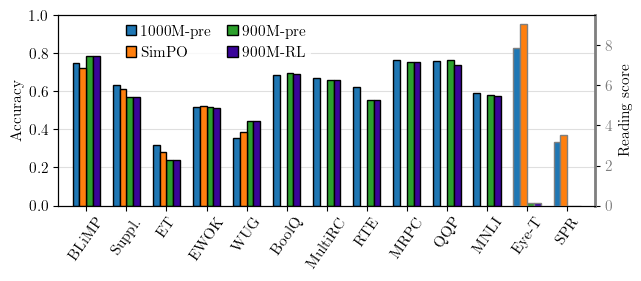

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ==== Load Data ====
df = pd.read_pickle("report_final.pkl")

# ==== Prepare Data (unify, add ET/SPR as separate tasks) ====

def unify_task(row):
    ttype = row["task_type"]
    if ttype == "finetune":
        return row["task"].lower()   # e.g., "boolq"
    if ttype == "zero_shot":
        return row["task"].lower()   # e.g., "blimp/blimp_filtered"
    return row["task"]

df = df.copy()
df["task_unified"] = df.apply(unify_task, axis=1)

# --- Extend TASK_DISPLAY and TASK_ORDER ---
TASK_DISPLAY = {
    "blimp/blimp_filtered": "BLiMP",
    "blimp/supplement_filtered": "Suppl.",
    "entity_tracking/entity_tracking": "ET",
    "ewok/ewok_filtered": "EWOK",
    "wug/wug_adj_nominalization": "WUG",
    "reading_et": "Eye-tracking",
    "reading_spr": "Self-paced",
    "boolq": "BoolQ",
    "multirc": "MultiRC",
    "rte": "RTE",
    "mrpc": "MRPC",
    "qqp": "QQP",
    "mnli": "MNLI"
}

TASK_ORDER = [
    "BLiMP", "Suppl.", "ET", "EWOK", "WUG",  # zero-shot tasks
    "BoolQ", "MultiRC", "RTE", "MRPC", "QQP", "MNLI", # finetune
    "Eye-T", "SPR"              # reading as two separate tasks at right
]

reading_bar_color = 'tab:gray'

# --- Prepare plot data ---

rows = []
for ix, row in df.iterrows():
    tu = row['task_unified']
    # Reading: create two rows per model!
    if tu == "reading":
        if pd.notnull(row.get('eye_tracking_score')):
            rd = row.copy()
            rd['task_display'] = 'Eye-T'
            rd['score'] = row['eye_tracking_score']
            rows.append(rd)
        if pd.notnull(row.get('selfpaced_reading_score')):
            rd = row.copy()
            rd['task_display'] = 'SPR'
            rd['score'] = row['selfpaced_reading_score']
            rows.append(rd)
    else:
        rd = row.copy()
        rd["task_display"] = TASK_DISPLAY.get(tu, tu)
        # main value: accuracy or average_accuracy
        rd["score"] = np.nan
        if rd["task_type"] == "finetune":
            rd["score"] = row.get("accuracy", np.nan)
        else:
            rd["score"] = row.get("average_accuracy", np.nan)
        rows.append(rd)
df_plot = pd.DataFrame(rows)
# Only use tasks included in the display
df_plot = df_plot[df_plot["task_display"].isin(TASK_ORDER)]

models_in_plot = list(MODEL_STYLE.keys())

# ---- Build final data table for plotting ----

data = []
for task_disp in TASK_ORDER:
    for model in models_in_plot:
        sel = (
            (df_plot["task_display"] == task_disp) &
            (df_plot["model_name"] == model)
        )
        score = df_plot[sel]["score"]
        if not score.empty:
            data.append({
                "Task": task_disp,
                "Model": model,
                "Score": score.values[0]
            })
        else:
            data.append({
                "Task": task_disp,
                "Model": model,
                "Score": np.nan     # to keep order intact
            })
plot_df = pd.DataFrame(data)

# --- Indices for left (normal) and right (reading) tasks
normal_tasks = [t for t in TASK_ORDER if t not in ["Eye-T", "SPR"]]
reading_tasks = ["Eye-T", "SPR"]
n_tasks = len(TASK_ORDER)

# --- Bar plot ---
fraction = 1.0 / 0.9569
figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.45)
fig, ax1 = plt.subplots(figsize=figsize)
ax2 = ax1.twinx()

width = 0.17
n_models = len(models_in_plot)
bar_group_offsets = np.arange(n_tasks)

for i, model in enumerate(models_in_plot):
    color = MODEL_STYLE[model]["color"]
    z = MODEL_STYLE[model]["zorder"]
    name = MODEL_STYLE[model]["name"]
    # -- Normal axis bars --
    norm_mask = plot_df["Task"].isin(normal_tasks) & (plot_df["Model"] == model)
    yvals_norm = plot_df.loc[norm_mask, "Score"].values
    norm_pos = [TASK_ORDER.index(t) for t in normal_tasks]
    ax1.bar(np.array(norm_pos) + i*width - (width*n_models/2) + width/2,
            yvals_norm,
            width=width,
            color=color,
            zorder=z,
            label=name,
            edgecolor='black')
    # -- Reading axis bars --
    for reading_task in reading_tasks:
        sel = (plot_df["Task"] == reading_task) & (plot_df["Model"] == model)
        read_score = plot_df.loc[sel, "Score"].values
        if len(read_score) == 1:
            xpos = TASK_ORDER.index(reading_task) + i*width - (width*n_models/2) + width/2
            ax2.bar(xpos,
                    read_score[0],
                    width=width,
                    color=color,
                    zorder=z,
                    edgecolor=reading_bar_color,
                    alpha=1)

# ----- Ticks and labels -----
ax1.set_xticks(np.arange(len(TASK_ORDER)))
ax1.set_xticklabels(TASK_ORDER, rotation=55, ha="center")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Reading score')
#ax1.set_xlabel('Task')

ax1.set_xlim(-0.7, n_tasks - 0.3)
ax1.set_ylim([0, 1])
# Optionally set tighter ylimits for reading, e.g. ax2.set_ylim([0, 10])
ax2.autoscale(axis='y')
for tl in ax2.get_yticklabels():
    tl.set_color(reading_bar_color)
for spine in ['right']:
    ax2.spines[spine].set_color(reading_bar_color)
    ax2.spines[spine].set_linewidth(2)

## Only show legend once
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1.02), ncols=2, columnspacing=1, frameon=True, edgecolor='None', borderpad=0.4, handlelength=0.7, handletextpad=0.3)
ax1.grid(axis='y', linestyle='-', alpha=0.4, zorder=1)
plt.tight_layout()
plt.savefig("figs/BLM_eval_final.pdf", bbox_inches='tight', pad_inches=0.03) #
check_pdf_size("figs/default_tokenizer/BLM_eval_final.pdf", figsize, fraction)
plt.show()

In [191]:
reading_tasks = ["Eye-T", "SPR"]  # use whatever display names are in your table/index

def custom_fmt(val, task):
    if pd.isnull(val):
        return ""
    if task in reading_tasks:
        return f"{val:.2f}"            # 2 decimals for ET/SPR
    else:
        return f"{val*100:.1f}"       # percent with 1 digit

table = plot_df.pivot(index="Task", columns="Model", values="Score")
table = table.reindex(TASK_ORDER)
table.columns = [MODEL_STYLE[m]["name"] if m in MODEL_STYLE else m for m in table.columns]

# Create a new object-typed DataFrame
table_formatted = pd.DataFrame(
    [[custom_fmt(table.loc[task, model], task) for model in table.columns] for task in table.index],
    index=table.index,
    columns=table.columns
)

latex_str = table_formatted.to_latex(
    index=True,
    escape=False,
    na_rep="",
    column_format="l" + "c" * len(table_formatted.columns),
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True
)
print(latex_str)

\begin{tabular}{lcccc}
\toprule
 & 1000M-pre & 900M-pre & 900M-RL & SimPO \\
Task &  &  &  &  \\
\midrule
\textbf{BLiMP} & 74.9 & 78.3 & 78.5 & 72.2 \\
\textbf{Suppl.} & 63.3 & 56.6 & 56.8 & 61.2 \\
\textbf{ET} & 31.5 & 24.0 & 23.8 & 28.1 \\
\textbf{EWOK} & 51.7 & 51.4 & 51.4 & 51.9 \\
\textbf{WUG} & 35.5 & 44.5 & 44.5 & 38.5 \\
\textbf{BoolQ} & 68.4 & 69.5 & 69.1 &  \\
\textbf{MultiRC} & 66.6 & 65.8 & 65.9 &  \\
\textbf{RTE} & 61.9 & 55.4 & 55.4 &  \\
\textbf{MRPC} & 76.5 & 75.0 & 75.0 &  \\
\textbf{QQP} & 75.9 & 76.5 & 73.9 &  \\
\textbf{MNLI} & 59.1 & 58.0 & 57.6 &  \\
\textbf{Eye-T} & 7.89 & 0.13 & 0.14 & 9.08 \\
\textbf{SPR} & 3.18 & 0.00 & 0.00 & 3.50 \\
\bottomrule
\end{tabular}



## Plot fast evals

In [83]:
import os
import re
import pandas as pd

def extract_results_from_file(file_path, scenario):
    print(f"[INFO] Extracting from: {file_path} | scenario: {scenario}")
    try:
        with open(file_path, 'r') as file:
            content = file.read()
    except Exception as e:
        print(f"[ERROR] Could not read file: {file_path} -- {e}")
        return {}
    results = {}
    if scenario == 'ewok_fast':
        temperature_match = re.search(r'TEMPERATURE: ([\d.]+)', content)
        if temperature_match:
            results['temperature'] = float(temperature_match.group(1))
        avg_acc = re.search(r'AVERAGE ACCURACY\n([\d.]+)', content)
        if avg_acc:
            results['average_accuracy'] = float(avg_acc.group(1))
    elif scenario == 'reading':
        correlations_file = file_path
        report_file = os.path.join(os.path.dirname(file_path), 'report.txt')
        if os.path.exists(report_file):
            with open(report_file, 'r') as report_file_obj:
                report_content = report_file_obj.read()
                eye_tracking_score_match = re.search(r'EYE TRACKING SCORE:\s+([\d.]+)', report_content)
                selfpaced_reading_score_match = re.search(r'SELF-PACED READING SCORE:\s+([\d.]+)', report_content)
                if eye_tracking_score_match:
                    results['eye_tracking_score'] = float(eye_tracking_score_match.group(1))
                if selfpaced_reading_score_match:
                    results['selfpaced_reading_score'] = float(selfpaced_reading_score_match.group(1))
    else:
        temperature_match = re.search(r'TEMPERATURE: ([\d.]+)', content)
        if temperature_match:
            results['temperature'] = float(temperature_match.group(1))
        avg_acc = re.search(r'AVERAGE ACCURACY\n([\d.]+)', content)
        if avg_acc:
            results['average_accuracy'] = float(avg_acc.group(1))
        if scenario == 'blimp_fast':
            # Locate the FIELD ACCURACY block
            field_acc_block = re.search(r'### FIELD ACCURACY\s*(.*?)(?:\n\n|$)', content, re.DOTALL)
            if field_acc_block:
                block = field_acc_block.group(1)
                # Extract lines like: syntax: 68.17
                for line in block.splitlines():
                    m = re.match(r'\s*([a-zA-Z/_]+):\s*([\d.]+)', line)
                    if m:
                        key = f"field_accuracy_{m.group(1).replace('/', '_')}"
                        results[key] = float(m.group(2))
    print(f"[INFO] Results extracted: {results}")
    return results

def extract_results_all_models(results_dir):
    print(f"[INFO] Scanning base dir: {results_dir}")
    rows = []
    subtask_scenario_map = {
        'blimp': ['blimp_fast', 'supplement_fast'],
        'entity_tracking': ['entity_tracking_fast'],
        'ewok': ['ewok_fast'],
        'reading': [],
        'wug': ['wug_adj_nominalization']
    }
    for model_name in sorted(os.listdir(results_dir)):
        model_dir = os.path.join(results_dir, model_name)
        if model_name.startswith('.') or not os.path.isdir(model_dir):
            continue
        print(f"[INFO] Processing model: {model_name}")
        revisions = [rev for rev in os.listdir(model_dir) if not rev.startswith('.')]
        for revision in revisions:
            revision_dir = os.path.join(model_dir, revision, 'zero_shot', 'causal')
            if not os.path.isdir(revision_dir):
                print(f"[WARN] Revision dir missing: {revision_dir}")
                continue
            for subtask, scenarios in subtask_scenario_map.items():
                subtask_dir = os.path.join(revision_dir, subtask)
                if not os.path.isdir(subtask_dir):
                    print(f"[WARN] Subtask dir missing: {subtask_dir}")
                    continue
                if subtask == 'reading':
                    correlations_file = os.path.join(subtask_dir, 'correlations.txt')
                    if not os.path.exists(correlations_file):
                        print(f"[WARN] No correlations file at {correlations_file}")
                        continue
                    results = extract_results_from_file(correlations_file, 'reading')
                    row = {
                        'model_name': model_name,
                        'revision': revision,
                        'scenario': 'reading'
                    }
                    row.update(results)
                    rows.append(row)
                else:
                    for scenario in scenarios:
                        scenario_dir = os.path.join(subtask_dir, scenario)
                        if not os.path.isdir(scenario_dir):
                            print(f"[WARN] Scenario dir missing: {scenario_dir}")
                            continue
                        file_path = os.path.join(scenario_dir, 'best_temperature_report.txt')
                        if not os.path.exists(file_path):
                            print(f"[WARN] Missing file: {file_path}")
                            continue
                        results = extract_results_from_file(file_path, scenario)
                        row = {
                            'model_name': model_name,
                            'revision': revision,
                            'scenario': scenario
                        }
                        row.update(results)
                        rows.append(row)
    df = pd.DataFrame(rows)

    # replace revision_number for PPO chck 'main' -> 1600K
    mask = df['model_name'].str.startswith("blm-gpt2s-90M-s42_")
    df.loc[mask & (df['revision'] == 'main'), 'revision'] = '1000K'

    # Extract and check revision_number
    df['revision_number'] = (
        df['revision']
          .str.extract(r'(\d+)')
          .astype(float)
    )

    bad_mask = df['revision_number'].isnull()
    if bad_mask.any():
        print(f"[WARN] Found {bad_mask.sum()} row(s) with bad/missing revision_number. These rows will be dropped.")
        print(df.loc[bad_mask, ['model_name', 'revision']])
        df = df.loc[~bad_mask].copy()
    df['revision_number'] = df['revision_number'].astype(int)
    print(f"[INFO] Extracted {len(df)} rows. Columns: {df.columns.tolist()}")
    return df

# Usage: extract results, save as pickle
results_dir = "eval/results"
df = extract_results_all_models(results_dir)
df.to_pickle('results_long.pkl')
print("[INFO] DataFrame saved to results_long.pkl")

[INFO] Scanning base dir: eval/results
[INFO] Processing model: babylm-baseline-100m-gpt2
[INFO] Extracting from: eval/results/babylm-baseline-100m-gpt2/chck_800M/zero_shot/causal/blimp/blimp_fast/best_temperature_report.txt | scenario: blimp_fast
[INFO] Results extracted: {'temperature': 1.0, 'average_accuracy': 75.07, 'field_accuracy_syntax': 71.58, 'field_accuracy_morphology': 88.19, 'field_accuracy_syntax_semantics': 69.89, 'field_accuracy_semantics': 67.0}
[INFO] Extracting from: eval/results/babylm-baseline-100m-gpt2/chck_800M/zero_shot/causal/blimp/supplement_fast/best_temperature_report.txt | scenario: supplement_fast
[INFO] Results extracted: {'temperature': 1.0, 'average_accuracy': 62.8}
[INFO] Extracting from: eval/results/babylm-baseline-100m-gpt2/chck_800M/zero_shot/causal/entity_tracking/entity_tracking_fast/best_temperature_report.txt | scenario: entity_tracking_fast
[INFO] Results extracted: {'temperature': 1.0, 'average_accuracy': 31.7}
[INFO] Extracting from: eval/res

In [84]:
import re

def extract_checkpoint_milestone(model_name):
    """
    Extracts the base checkpoint milestone as an integer from model name.
    Example:
      "babylm-gpt2-small-90M-seed41_chck_500M_ppo-1600K-seed41" => 500000000
    """
    m = re.search(r'_chck_(\d+)([MK])_', model_name)
    if not m:
        return None
    number, unit = m.groups()
    number = int(number)
    return number

# Create new PPO_revision_number column mirroring current revision_number
df['PPO_revision_number'] = df['revision_number']

# Apply checkpoint milestone update only for affected models
mask = df['model_name'].str.startswith("blm-gpt2s-90M-s42_")

# Parse milestone and update revision_number accordingly
def update_revision_number(row):
    if not mask.loc[row.name]:
        return row['revision_number']
    milestone = extract_checkpoint_milestone(row['model_name'])
    if milestone is not None:
        return milestone
    return row['revision_number']

df.loc[mask, 'revision_number'] = df.loc[mask].apply(update_revision_number, axis=1)

- **BoolQ** &nbsp; — Boolean Questions
- **MultiRC** &nbsp; — Multi-sentence Reading Comprehension ([arXiv:2410.15997](https://arxiv.org/abs/2410.15997))
- **RTE** &nbsp; — GLUE inference: Recognizing Textual Entailment
- **MRPC** &nbsp; — GLUE similarity and paraphrase: Microsoft Research Paraphrase Corpus
- **QQP** &nbsp; — GLUE similarity and paraphrase: Quora Question Pairs
- **MNLI** &nbsp; — GLUE inference: Multi-Genre Natural Language Inference

Tentative conclusions:
1. Both model suspiciously similar: If the SimPO model were entirely RL-trained that would be highly surprising. Perhaps this shows that the weaker $0.2$ portion of next-level prediction is sufficient and carries the model training, whereas the RL is redundant?
2. BLiMP and BLiMP supplement improve over training
3. Entity tracking and WUG Test get worse
4. EWOK is random baseline
5. Reading is constant

#### BLiMP fields

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from matplotlib.ticker import LogLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt


# Font config
fontsize = 11
init_latex(fontsize)

baseline = 'blm-gpt2s-90M-s42_submission'

# Models and checkpoints of interest
models_ppo_steps = ['20M', '90M', '200M', '500M', '900M']
models_ppo_steps_num = [20, 90, 200, 500, 900]
ppo_suffix = '_ppo-1600K-seed41'
models_ppo = [f'{baseline}_chck_{step}{ppo_suffix}' for step in models_ppo_steps]

# Red colormap for PPO models
red_cmap = plt.get_cmap("Reds")
n_ppos = len(models_ppo)
ppo_colors = [red_cmap(0.3 + 0.7*i/(n_ppos-1)) for i in range(n_ppos)]  # from lighter to darker red

# Explicitly listed "special" models
SPECIAL_MODELS = {
    'babylm-baseline-100m-gpt2': {"display": r"1000M", "color": "black", "zorder": 1},
    'babylm-interaction-baseline-simpo': {"display": r"SimPO", "color": "gray", "zorder": 2},
    baseline: {"display": r"900M-pre", "color": "tab:blue", "zorder": 3}
}

# Helper to extract PPO checkpoint from model name
def get_ppo_step(modelname):
    match = re.search(r'_chck_(\d+M)_ppo-1000K-seed42$', modelname)
    return match.group(1) if match else None

# Generate displays/zorder/colors in a concise way
MODEL_DISPLAY = {k: v["display"] for k, v in SPECIAL_MODELS.items()}
MODEL_ZORDER  = {k: v["zorder"]  for k, v in SPECIAL_MODELS.items()}
MODEL_COLORS  = {k: v["color"]   for k, v in SPECIAL_MODELS.items()}

for i, model in enumerate(models_ppo):
    step = get_ppo_step(model) or '???'
    MODEL_DISPLAY[model] = fr"{step}"
    MODEL_ZORDER[model]  = 4  # could customize per step if needed
    MODEL_COLORS[model]  = ppo_colors[i]  # or use colors from ppo_colors if desired

TASK_DISPLAY = {
    "blimp_fast": "BLiMP",
    "supplement_fast": "Suppl.",
    "entity_tracking_fast": "ET",
    "ewok_fast": "EWOK",
    "wug_adj_nominalization": "WUG",
    "reading": "Read",
    "BoolQ": "BoolQ",
    "MultiRC": "MultiRC",
    "RTE": "RTE",
    "MRPC": "MRPC",
    "QQP": "QQP",
    "MNLI": "MNLI"
}


=== PDF actual area ===:
  450.35pt x 185.05pt  ||  6.2549in x 2.5702in
=== Your target figsize from set_size, corrected for fraction:
  451.00pt x 189.42pt  ||  6.2639in x 2.6309in
=== Ratio (actual/target):
  width: 99.85%,  height: 97.69%


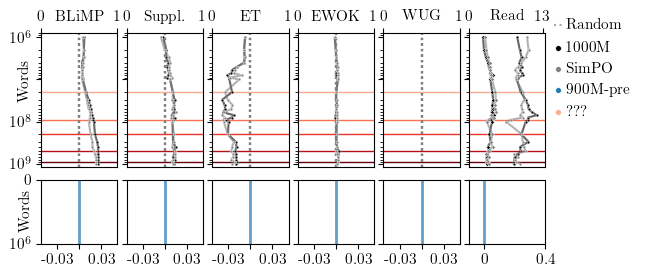

In [87]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# ...everything else (model/color/task setup) as before...

# TASK/PANEL ORDER
MAIN_TASKS = [t for t in df['scenario'].unique()
              if t not in ["reading", "wug_adj_nominalization"]]
panel_order = MAIN_TASKS[:4] + ["wug_adj_nominalization", "reading"]

n_tasks = len(panel_order)
n_cols = n_tasks

fontsize = 11
markersize = 2
markeredgewidth = 0.3
mec = "white"

# ---- PANEL SETUP: 2 ROWS; bottom row 1/2 height of top row ----
height_ratios = [2.1, 1]  # top:bottom = 2:1
fraction = 1/0.9623
figsize = set_size(ncols=2, aspect_ratio=0.42, fraction=fraction)
fig = plt.figure(figsize=figsize)

gs = gridspec.GridSpec(2, n_cols, height_ratios=height_ratios, hspace=0.13, wspace=0.12)
main_axes = [fig.add_subplot(gs[0, i]) for i in range(n_cols)]
diff_axes = [fig.add_subplot(gs[1, i]) for i in range(n_cols)]

# ---------- MAIN ACCURACY PANELS (TOP ROW) ----------
for idx, (ax, task) in enumerate(zip(main_axes, panel_order)):
    task_df = df[df['scenario'] == task]
    plotted_any = False

    if task == "reading":
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name']==model_name].sort_values('revision_number')
            y = dfm['revision_number'].values
            x_eye = dfm['eye_tracking_score'].values if 'eye_tracking_score' in dfm.columns else []
            x_self = dfm['selfpaced_reading_score'].values if 'selfpaced_reading_score' in dfm.columns else []
            color = MODEL_COLORS.get(model_name)
            zorder = MODEL_ZORDER.get(model_name, 0)
            # Plot eye tracking score
            ax.scatter(x_eye, y, color=color, marker='o', s=markersize**2, label=MODEL_DISPLAY.get(model_name),
                       edgecolors=mec, linewidths=markeredgewidth, zorder=zorder)
            ax.plot(x_eye, y, color=color, marker='None', linestyle='-', alpha=0.6, zorder=zorder-1)
            # Plot selfpaced reading score
            ax.scatter(x_self, y, color=color, marker='D', s=markersize**2, label=MODEL_DISPLAY.get(model_name),
                   edgecolors=mec, linewidths=markeredgewidth, zorder=zorder)
            ax.plot(x_self, y, color=color, marker='None', linestyle='-', alpha=0.6, zorder=zorder-1)
        ax.set_xlim(0, 13.5)
        ax.set_xticks([0, 13])
    else:
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name']==model_name].sort_values('revision_number')
            y = dfm['revision_number'].values
            x = (dfm['average_accuracy'].values) / 100
            color = MODEL_COLORS.get(model_name)
            zorder = MODEL_ZORDER.get(model_name, 0)
            ax.axvline(x=0.5, ls=':', color='gray', alpha=0.7, label="Random", zorder=0)
            ax.scatter(x, y, color=color, marker='o', s=markersize**2, label=MODEL_DISPLAY.get(model_name),
                       edgecolors=mec, linewidths=markeredgewidth, zorder=zorder)
            ax.plot(x, y, color=color, marker='None', alpha=0.6, zorder=zorder-1)
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 1])

    # Formatting: Y axis for words, log, invert so 'largest' at top
    ax.set_yscale('log')
    ax.set_ylim(0.8, 1200)
    ax.invert_yaxis()
    # Y label & titles
    if idx == 0:
        ax.set_ylabel(r'Words')
        ax.yaxis.set_label_coords(-0.13, 0.64)
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(
                lambda y, _: (
                    r'$10^6$' if np.isclose(y, 1) else
                    r'$10^8$' if np.isclose(y, 100) else
                    r'$10^9$' if np.isclose(y, 1000) else
                    ''
                )
            )
        )
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    display_title = TASK_DISPLAY.get(task, str(task))

    ax.set_xlabel(display_title, fontsize=fontsize, labelpad=-8)
    ax.xaxis.set_label_position('top')

    #ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)


    # Add horizontal lines where PPO models where evaluated
    for i, model_name in enumerate(models_ppo):
        color = MODEL_COLORS[model_name]
        ax.axhline(y=models_ppo_steps_num[i], color=color, alpha=1, linewidth=1, zorder=-1)  # low alpha, slightly thicker for visibility


# Create legend only with unique handles/labels
handles = []
labels = []
for ax in main_axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
if handles:
    fig.legend(handles, labels, loc='upper right', ncol=1, frameon=False, markerscale=2,
               handlelength=0.5, handletextpad=0.3, columnspacing=1.0, bbox_to_anchor=(1.05, 0.98))

# ---------- DELTA ROW (BOTTOM PANELS) ----------
for idx, (ax, task) in enumerate(zip(diff_axes, panel_order)):
    task_df = df[df['scenario']==task]
    baseline_df = task_df[task_df['model_name'] == baseline].sort_values('revision_number')
    y_base = baseline_df['revision_number'].values
    if task == "reading":
        # Prepare: baseline by revision_number
        eye_base = baseline_df['eye_tracking_score'].values if 'eye_tracking_score' in baseline_df.columns else []
        self_base = baseline_df['selfpaced_reading_score'].values if 'selfpaced_reading_score' in baseline_df.columns else []
        # Construct baseline dicts for easy lookup
        baseline_eye_dict = dict(zip(y_base, eye_base))
        baseline_self_dict = dict(zip(y_base, self_base))

        for i, model_name in enumerate(models_ppo):
            dfm = task_df[task_df['model_name'] == model_name].sort_values('PPO_revision_number')
            y = dfm['PPO_revision_number'].values / 1000  # PPO words [M]
            # Eye-tracking difference
            eye = dfm['eye_tracking_score'].values if 'eye_tracking_score' in dfm.columns else []
            eye_base_vals = np.array([baseline_eye_dict.get(xx, np.nan) for xx in dfm['revision_number'].values])
            delta_eye = eye - eye_base_vals
            if len(y) and len(delta_eye):
                ax.plot(delta_eye, y, color=ppo_colors[i], marker='o', markersize=markersize,
                        markeredgecolor=mec, markeredgewidth=markeredgewidth, linestyle='-', label="Eye", zorder=MODEL_ZORDER.get(model_name, 0))
            # Self-paced difference
            self_val = dfm['selfpaced_reading_score'].values if 'selfpaced_reading_score' in dfm.columns else []
            self_base_vals = np.array([baseline_self_dict.get(xx, np.nan) for xx in dfm['revision_number'].values])
            delta_self = self_val - self_base_vals
            if len(y) and len(delta_self):
                ax.plot(delta_self, y, color=ppo_colors[i], marker='D', markersize=markersize,
                        markeredgecolor=mec, markeredgewidth=markeredgewidth, linestyle='--', label="Self-paced", zorder=MODEL_ZORDER.get(model_name, 0))
    else:
        acc_base = (baseline_df['average_accuracy'].values) / 100
        baseline_dict = dict(zip(y_base, acc_base))
        for i, model_name in enumerate(models_ppo):
            dfm = task_df[task_df['model_name']==model_name].sort_values('PPO_revision_number')
            y = dfm['PPO_revision_number'].values / 1000  # PPO words [M] -> yaxis
            x = (dfm['average_accuracy'].values) / 100
            baseline_y = np.array([baseline_dict.get(xx, np.nan) for xx in dfm['revision_number'].values])
            delta_x = x - baseline_y
            label = MODEL_DISPLAY.get(model_name, model_name)
            zorder = MODEL_ZORDER.get(model_name, 0)
            ax.plot(delta_x, y, color=ppo_colors[i], marker='o', markersize=markersize,
                       markeredgecolor=mec, markeredgewidth=markeredgewidth, label=label, zorder=zorder)
    # Formatting for bottom panel
    ax.axvline(x=0, ls='-', color=MODEL_COLORS.get(baseline), lw=2, alpha=0.7, zorder=0)
    ax.set_ylim(0, 1.6)
    ax.set_yscale("linear")
    ax.invert_yaxis()  # Make larger PPO words (higher y) at the top (to match top panel)
    ax.set_yticks([0,1.6])
    ax.set_yticklabels([0,r'$10^6$'])
    if idx == 0:
        ax.set_ylabel(r'Words', labelpad=-16)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    if task == 'reading':
        ax.set_xlim(-0.1, 0.4)  # Adjust based on your reading scores range
        ax.set_xticks([0, 0.4])
        ax.set_xticklabels([0, 0.4])
    else:
        ax.set_xlim(-0.052, 0.052)
        ax.set_xticks([-0.03, 0, 0.03])
        ax.set_xticklabels([-0.03, '', 0.03])
    #ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)

plt.savefig("figs/BLM_eval_fast.pdf", bbox_inches='tight', pad_inches=0)
check_pdf_size("figs/default_tokenizer/BLM_eval_fast.pdf", figsize, fraction)
plt.show()

Add insets of differences 900M to baseline

At first glance: PPO does not affect the BabyLM evals much. -> Does not deteriorate formal linguistic capabilities while improving functional linguistic capabilities.

/var/folders/wp/kjl989ld3zddc7kyh9hhp1x80000gn/T/ipykernel_2996/934594213.py:105: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 1])


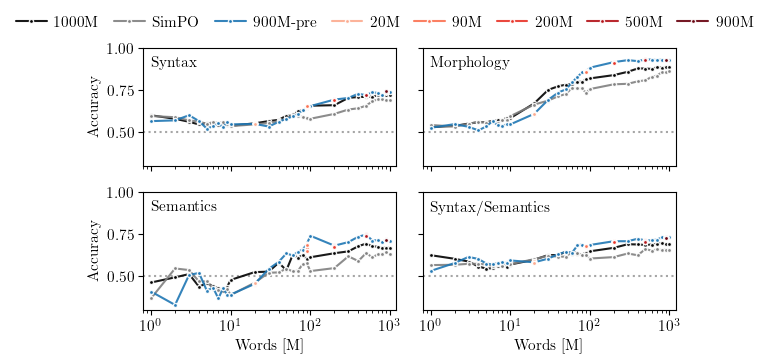

In [568]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator

fontsize = 11
init_latex(fontsize)

# List and display names of BLiMP fields
blimp_fields = [
    'field_accuracy_syntax',
    'field_accuracy_morphology',
    'field_accuracy_semantics',
    'field_accuracy_syntax_semantics'
]
field_labels = [
    'Syntax', 'Morphology', 'Semantics', 'Syntax/Semantics'
]
field_display_map = dict(zip(blimp_fields, field_labels))

model_names = MODEL_DISPLAY.keys()
markersize = 3
mec = "1.0"

fig_width_pt = 200
figsize = set_size(fig_width_pt, fraction=1, aspect_ratio=0.55)
fig, axes = plt.subplots(2, 2, figsize=figsize)
axes = axes.flatten()

linestyles = ['-', '-', '-', '-']

for fidx, (field, field_label) in enumerate(zip(blimp_fields, field_labels)):
    ax = axes[fidx]
    for midx, model_name in enumerate(model_names):
        blimp_df = df[(df['scenario'] == 'blimp_fast') & (df['model_name'] == model_name)].sort_values('revision_number')
        if field in blimp_df.columns:
            x = blimp_df['revision_number']
            y = blimp_df[field].values / 100.0
            if len(x) and len(y):
                label = MODEL_DISPLAY.get(model_name, model_name)
                color = MODEL_COLORS.get(model_name, None)
                ax.plot(
                    x, y,
                    label=label,
                    color=color,
                    linestyle=linestyles[midx % len(linestyles)],
                    marker='o',
                    markersize=markersize,
                    mec=mec,
                    alpha=0.9
                )
    ax.axhline(y=0.5, ls=':', color='gray', alpha=0.7, label=None, zorder=0)
    ax.set_ylim(0.3, 1.00)
    # Internal title on the top-left
    ax.text(
        0.03, 0.93, field_label,
        fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )
    ax.set_xscale('log')
    ax.set_xlim(0.8, 1200)
    ax.xaxis.set_major_locator(LogLocator(base=10.0))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    #ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    if fidx % 2 == 0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_yticklabels([])
    if fidx // 2 == 1:
        ax.set_xlabel(r'Words [M]')
    else:
        ax.set_xticklabels([])

# Remove any unused axes
for f in range(len(blimp_fields), len(axes)):
    axes[f].axis('off')

# Put joint legend at top center, outside grid
handles, labels = axes[0].get_legend_handles_labels()
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
fig.legend(
    by_label.values(),
    by_label.keys(),
    loc='upper center',
    ncol=len(by_label),
    frameon=False,
    handletextpad=0.5,
    columnspacing=1.0,
    bbox_to_anchor=(0.5, 1.07)
)
#fig.text(
#    0.504, 0.17, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)
#fig.text(
#    0.964, 0.17, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("figs/BLM_eval_fast_BLiMP_fields.pdf")
plt.show()

Perhaps for the appendix.

#### Load Wandb runs for GLUE finetuning

In [33]:
WANDB_PROJECT="BLM_eval_finetuning"
WANDB_ENTITY=""

In [495]:
import wandb
import pandas as pd  # Needed for df
import os
import pandas as pd

def save_history(history_df, model_label, run_id, base_dir="eval/history_finetune"):
    folder = os.path.join(base_dir, model_label)
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"{run_id}.parquet")
    history_df.to_parquet(path)  # or use .to_csv(path), if preferred

def load_history(model_label, run_id, base_dir="eval/history_finetune"):
    path = os.path.join(base_dir, model_label, f"{run_id}.parquet")
    if os.path.exists(path):
        return pd.read_parquet(path)
    else:
        return None

# 0. Setup: tasks, models, run_ids (raw mapping)
tasks = ["BoolQ", "MultiRC", "RTE", "MRPC", "QQP", "MNLI"]
model_keys = [
    "babylm-baseline-100m-gpt2",         # 1000M
    "babylm-interaction-baseline-simpo", # SimPO
    "babylm-gpt2-small-90M-seed41",      # 900M-pre
    "babylm-gpt2-small-90M-seed41_chck_900M_ppo-1600K-seed41"  # PPO-900M
]
run_ids_by_model = [
    ["sdn52gud", "t0ctufpk", "jz88029a", "m3511x7c", "et93fc2i", "ii86bwdx"], # 1000M
    ["7wqfbbno", "jm3bs8wi", "fsppjjb5", "xkrxziyt", "mv9dpmrp", "7vuft57i"], # SimPO
    ["26ccswxv", "u1mllgay", "mly9b0zr", "stwp4qts", "iyfjzsp7", "pv6gqn0x"], # 900M-pre
    ["jw3am5vx", "ixrt9305", "0jbub8w9", "n5gt1e9k", "lledh9ef", "b0h6xudl"]  # PPO-900M
]

# 1. Compose display/color dicts
MODEL_DISPLAY  = {k: v["display"] for k, v in SPECIAL_MODELS.items()}
MODEL_DISPLAY["babylm-gpt2-small-90M-seed41_chck_900M_ppo-1600K-seed41"] = fr"900M"
MODEL_COLORS   = {k: v["color"]   for k, v in SPECIAL_MODELS.items()}
MODEL_COLORS["babylm-gpt2-small-90M-seed41_chck_900M_ppo-1600K-seed41"] = ppo_colors[-1]

# 2. Compose: short display->color for fast lookups if you use display names as keys
FINETUNE_MODEL_COLORS = {v["display"]: v["color"] for v in SPECIAL_MODELS.values()}
FINETUNE_MODEL_COLORS["900M"] = ppo_colors[-1]

# 3. Create the concise run_info dictionary
run_info = {}
for modkey, run_id_list in zip(model_keys, run_ids_by_model):
    display = MODEL_DISPLAY[modkey]
    color   = MODEL_COLORS[modkey]
    for runid, task in zip(run_id_list, tasks):
        run_info[runid] = (rf"\textbf{{{task}}}", display, color)

accuracy = {}
for run_id, (task, model_label, color) in run_info.items():
    hist_local = load_history(model_label, run_id)
    if hist_local is not None:
        history = hist_local
    else:
        # Download from W&B if not found locally
        api = wandb.Api()
        run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_id}")
        all_rows = [row for row in run.scan_history()]
        if not all_rows:
            continue
        history = pd.DataFrame(all_rows)
        save_history(history, model_label, run_id)
    accuracy[run_id] = (task, model_label, color, history)

Save finetune data locally

=== PDF actual area ===:
  450.86pt x 97.67pt  ||  6.2619in x 1.3566in
=== Your target figsize from set_size, corrected for fraction:
  451.00pt x 81.18pt  ||  6.2639in x 1.1275in
=== Ratio (actual/target):
  width: 99.97%,  height: 120.32%


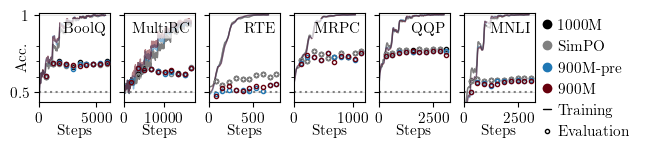

In [625]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
import matplotlib.lines as mlines

init_latex(fontsize=11)
roll_sigma = 20
markersize = 3
markeredgewidth = 1
mec = "white"
fontsize = 11

# Group runs by task
task_runs = defaultdict(list)
for run_id, (task, model_label, color, history) in accuracy.items():
    task_name = task.replace("\\textbf{", "").replace("}", "")
    task_runs[task_name].append((model_label, color, history))

tasks = ["BoolQ", "MultiRC", "RTE", "MRPC", "QQP", "MNLI"]
ORDERED_MODEL_LABELS = ["1000M", "SimPO", "900M-pre", "900M"]

fraction = 1. / 0.98
figsize = set_size(ncols=2, aspect_ratio=0.18, fraction=fraction)  # One row, wide aspect
fig, axes = plt.subplots(1, 6, figsize=figsize)
axes = np.array(axes).flatten()

for idx, (task, ax) in enumerate(zip(tasks, axes)):
    runs = task_runs[task]
    max_eval_step = 0
    for model_label, color, history in runs:
        steps = history["_step"].values
        train = history["train/accuracy"].values

        # Gaussian smoothing, plot every 100th point
        smoothed = gaussian_filter1d(train, sigma=roll_sigma)
        plot_idx = np.arange(0, len(steps), 20)
        ax.plot(steps[plot_idx], smoothed[plot_idx], color=color, alpha=0.5, lw=1)

        # Eval accuracy, plot as dots/lines
        eval_acc = history["evaluate/accuracy"]
        mask = eval_acc.notnull()
        eval_steps = steps[mask]
        eval_vals = eval_acc[mask]
        if len(eval_steps):
            max_eval_step = max(max_eval_step, np.max(eval_steps))
            ax.plot(
                eval_steps, eval_vals, color='None',
                marker="o", markeredgecolor=color, markersize=markersize, markeredgewidth=markeredgewidth, linestyle='None', zorder=5
            )

    # Baseline at 0.5
    ax.axhline(y=0.5, xmin=0, xmax=max_eval_step, linestyle=":", color="gray", label=None)

    # X-ticks at 0 and last eval step for this panel
    #xticks = [0, int(max_eval_step)]
    #ax.set_xticks(xticks)
    ax.set_xlim(0, 1.05 * max_eval_step)
    #ax.set_xticklabels([str(x) for x in xticks])
    ax.set_xlabel("Steps", labelpad=-1)

    # Show all y-tick labels (default)
    if idx == 0:
        ax.set_ylabel("Acc.", labelpad=-14)
        ax.set_yticks([0.5, 1])
        ax.set_yticks([0.6, 0.7, 0.8], minor=True)
        ax.set_yticklabels([0.5, 1])
    else:
        ax.set_yticks([0.5, 1])
        ax.set_yticks([0.6, 0.7, 0.8], minor=True)
        ax.set_yticklabels([])

    # Panel title (top left)
    if idx == 1:
        shift_text = 0 * -0.3
    else:
        shift_text = 0
    ax.text(
        0.94 + shift_text, 0.9, task, fontsize=fontsize, weight="bold",
        ha="right", va="top", transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )

    ax.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylim(0.44, 1.01)

MODEL_NAMES = [MODEL_DISPLAY.get(m, m) for m in set(model_label for runs in task_runs.values() for model_label, _, _ in runs)]

# Build one Line2D per model for the legend
model_handles = [
    mlines.Line2D([], [], color=FINETUNE_MODEL_COLORS[name], label=name, lw=1, marker="o")
    for name in ORDERED_MODEL_LABELS
]

# For train/eval styles (generic icons for the legend)
train_handle = mlines.Line2D([], [], color="black", lw=1, alpha=1)
eval_handle  = mlines.Line2D([], [], color="none", marker="o", markeredgecolor="black",
                             markerfacecolor="none", markersize=markersize,
                             markeredgewidth=markeredgewidth, linestyle="None",
                             label="Eval points")

fig.legend(
    model_handles + [train_handle, eval_handle],
    [h.get_label() for h in model_handles] + ["Training", "Evaluation"],
    loc='upper right', ncol=1, frameon=False, markerscale=1,
    handletextpad=0.5, handlelength=0.5, columnspacing=1.0, bbox_to_anchor=(1.071, 0.95)
)

#plt.subplots_adjust(wspace=0.19, hspace=0.01)
plt.savefig("figs/BLM_eval_finetune.pdf", bbox_inches='tight', pad_inches=0)
check_pdf_size("figs/default_tokenizer/BLM_eval_finetune.pdf", figsize, fraction)
plt.show()





---



---

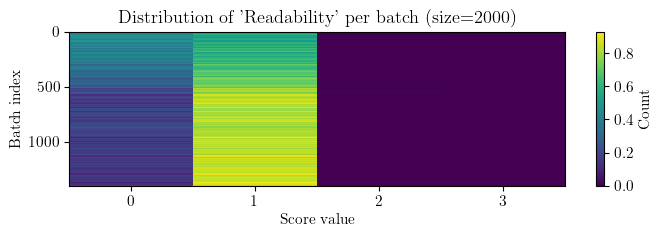

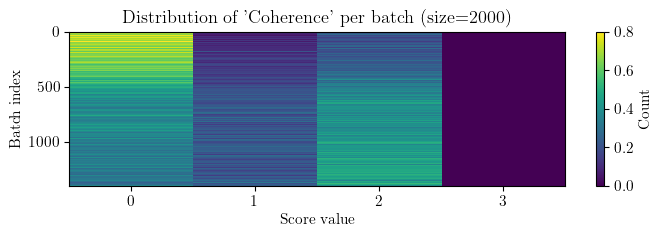

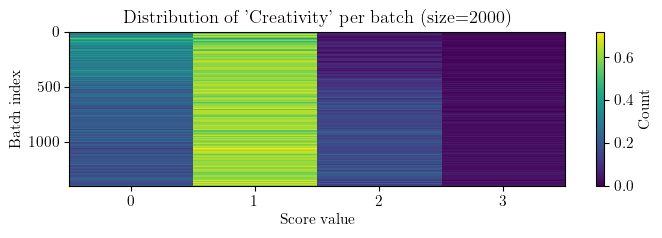

In [225]:
import numpy as np
import matplotlib.pyplot as plt


score_list = ['Readability', 'Coherence', 'Creativity']

for score in score_list:
    possible_values = [0, 1, 2, 3]

    # Group into batches
    df_batch_stats['batch'] = df_batch_stats.index // batch_size

    # Make a batch x value matrix
    counts = []
    batches = df_generated['batch'].unique()
    for batch_num in batches:
        batch = df_generated[df_generated['batch'] == batch_num][score]
        vals = [np.sum(batch == v) / len(batch) for v in possible_values]
        counts.append(vals)
    counts = np.array(counts) # shape: num_batches x 4

    plt.figure(figsize=(8, 2))
    plt.imshow(counts, aspect='auto', cmap='viridis', interpolation='none')
    plt.title(f"Distribution of '{score}' per batch (size={batch_size})")
    plt.xlabel("Score value")
    plt.ylabel("Batch index")
    plt.xticks(range(4), possible_values)
    plt.colorbar(label='Count')
    plt.show()

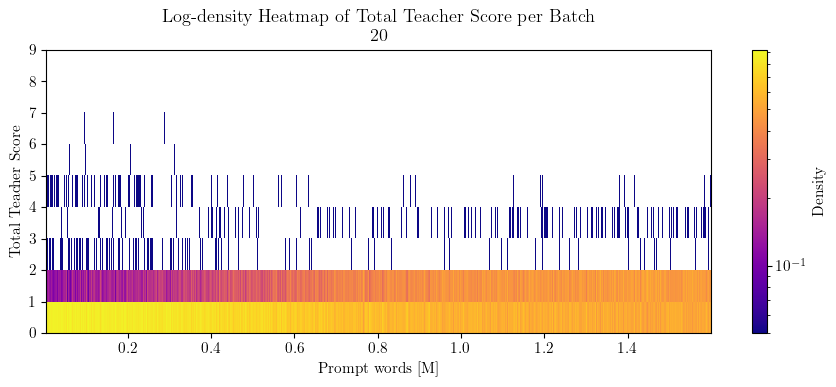

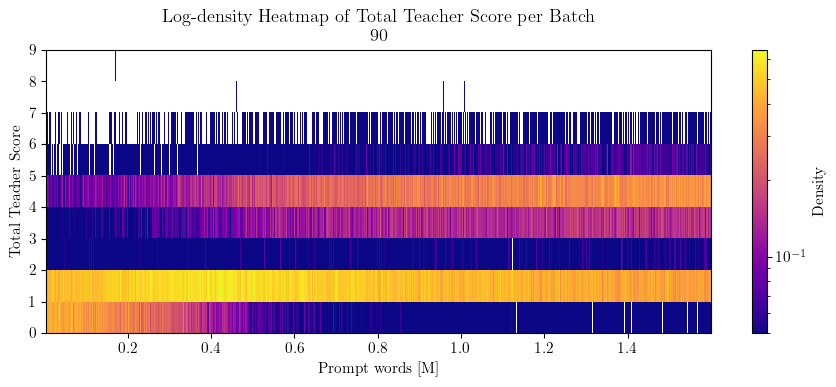

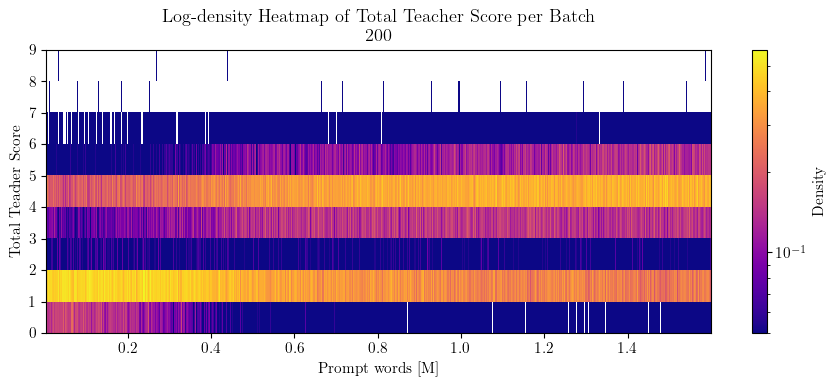

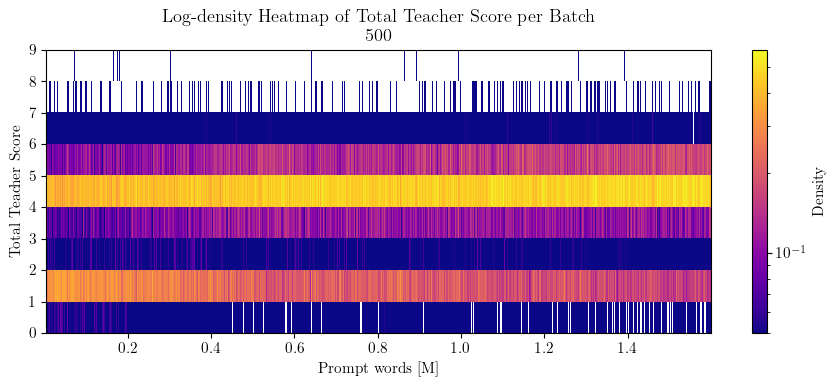

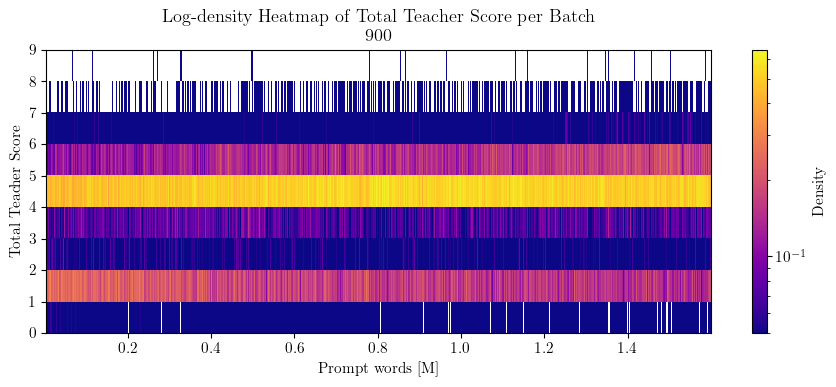

In [240]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# For each revision/model
bin_edges = np.arange(0, 10, 1)
revision_numbers = sorted(generated_dict.keys(), key=lambda x: int(str(x).replace('M','')))

for revision in revision_numbers:
    df_generated = generated_dict[revision].copy()
    df_batch = batch_stats_dict[revision]

    # You may need to reconstruct the batch column, depending on your data
    if 'batch' not in df_generated.columns:
        batch_size = len(df_generated) // len(df_batch)
        df_generated['batch'] = df_generated.index // batch_size

    # Use cumulative prompt words as X axis
    prompt_words = df_batch['prompt_words'].values / 1e6  # in millions
    batches = np.sort(df_generated['batch'].unique())

    densities_matrix = []
    for batch in batches:
        batch_scores = df_generated[df_generated['batch'] == batch][('score_sum')]
        counts, _ = np.histogram(batch_scores, bins=bin_edges)
        # Normalize to density for the batch (avoid division by 0)
        if len(batch_scores) > 0:
            density = counts / len(batch_scores)
        else:
            density = np.zeros(len(bin_edges) - 1)
        densities_matrix.append(density)

    densities_matrix = np.array(densities_matrix).T  # [n_bins, n_batches]

    plt.figure(figsize=(9, 4))
    # For extent: x goes from first to last prompt_words
    im = plt.imshow(
        densities_matrix,
        aspect='auto', origin='lower', cmap='plasma',
        extent=[prompt_words[0], prompt_words[-1], bin_edges[0], bin_edges[-1]],
        interpolation='nearest',
        norm=LogNorm(
            vmin=max(densities_matrix[densities_matrix > 0].min(), 5e-2),
            vmax=max(densities_matrix.max(), 1e-1)
        )
    )

    plt.colorbar(im, label='Density')
    plt.xlabel('Prompt words [M]')
    plt.ylabel('Total Teacher Score')
    plt.title(f'Log-density Heatmap of Total Teacher Score per Batch\n{revision}')
    plt.tight_layout()
    plt.show()

/var/folders/wp/kjl989ld3zddc7kyh9hhp1x80000gn/T/ipykernel_3175/690732440.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


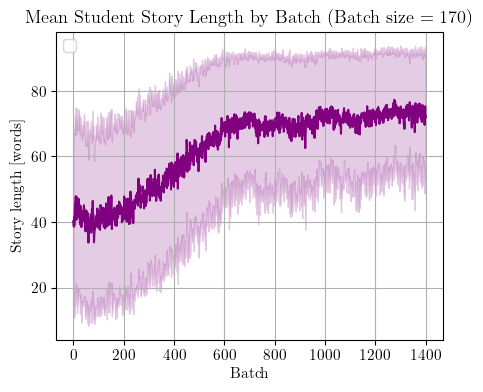

In [388]:
import matplotlib.pyplot as plt

batch_size = 170
df_generated['batch'] = df_generated.index // batch_size

# Compute mean and standard deviation of story length per batch
batch_means = df_generated.groupby('batch')['story_length'].mean()
batch_stds = df_generated.groupby('batch')['story_length'].std()

x = batch_means.index
y = batch_means.values
err = batch_stds.values

plt.figure(figsize=(5, 4))
plt.plot(x, y, color='purple')
plt.fill_between(x, y-err, y+err, color='purple', alpha=0.2)
plt.xlabel('Batch')
plt.ylabel('Story length [words]')
plt.title(f'Mean Student Story Length by Batch (Batch size = {batch_size})')
plt.grid(True)
plt.legend()
plt.show()

/var/folders/wp/kjl989ld3zddc7kyh9hhp1x80000gn/T/ipykernel_6418/2682956050.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([f"{int(tick)}" for tick in cbar.get_ticks()])  # make labels integer if you want


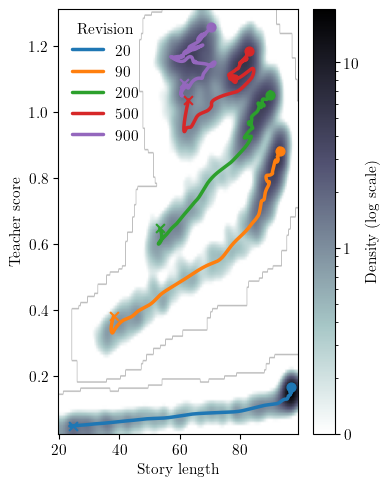

In [353]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from matplotlib.colors import LogNorm, LinearSegmentedColormap

sigma = 20
cmap = plt.get_cmap('tab10')
revision_numbers = sorted(
    batch_stats_dict.keys(),
    key=lambda x: int(str(x).replace('M',''))
)
colors = [cmap(i) for i in range(len(revision_numbers))]

# ------ Gather all points ------
all_story_len = []
all_score = []

for revision in revision_numbers:
    df = batch_stats_dict[revision]
    all_story_len.append(df['student_len'].to_numpy())
    all_score.append(df['avg_teacher_reward'].to_numpy() * 3)
story_len_all = np.concatenate(all_story_len)
score_all = np.concatenate(all_score)

xbins = np.linspace(story_len_all.min(), story_len_all.max(), 140)
ybins = np.linspace(score_all.min(), score_all.max(), 140)
H, xedges, yedges = np.histogram2d(story_len_all, score_all, bins=[xbins, ybins])
H_smooth = gaussian_filter(H, sigma=2)

plt.figure(figsize=(4, 5))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot the heatmap
im = plt.imshow(
    H_smooth.T,
    extent=extent,
    aspect='auto',
    origin='lower',
    cmap='bone_r',
    norm=LogNorm(vmin=0.1 , vmax=H_smooth.max()) # H_smooth[H_smooth > 0].min()
)

# Overlay model curves
for color, revision in zip(colors, revision_numbers):
    df = batch_stats_dict[revision]
    story_len = df['student_len'].to_numpy()
    score = df['avg_teacher_reward'].to_numpy() * 3

    student_len_smooth = gaussian_filter1d(story_len, sigma=sigma, mode='nearest')
    score_smooth = gaussian_filter1d(score, sigma=sigma, mode='nearest')

    plt.plot(student_len_smooth, score_smooth, linewidth=2.5, color=color, label=revision, zorder=3)
    plt.scatter(student_len_smooth[0], score_smooth[0], marker='x', color=color, s=40, zorder=4)
    plt.scatter(student_len_smooth[-1], score_smooth[-1], marker='o', color=color, s=40, zorder=4)

plt.xlabel('Story length')
plt.ylabel('Teacher score')

# Logarithmic colorbar
cbar = plt.colorbar(im, label='Density (log scale)')
cbar.ax.set_yticklabels([f"{int(tick)}" for tick in cbar.get_ticks()])  # make labels integer if you want

plt.legend(title="Revision", frameon=False)
plt.tight_layout()
plt.show()

In [ ]:

#fig.text(
#    0.334, 0.12, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)
#fig.text(
#    0.656, 0.12, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)
#fig.text(
#    0.984, 0.12, r'$\times 10^6$',
#    ha='right', va='bottom',
#    fontsize=fontsize,
#    color='black'
#)

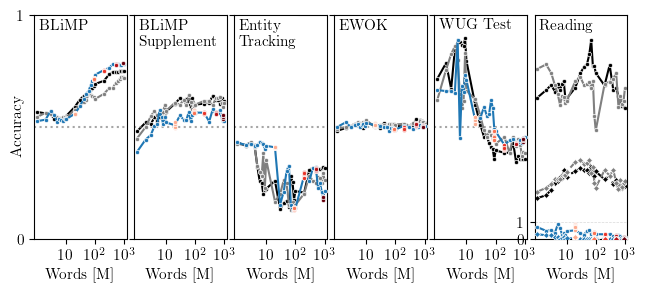

In [485]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import LogLocator

# Font config
fontsize = 11
init_latex(fontsize)

import re
import matplotlib.pyplot as plt

baseline = 'babylm-gpt2-small-90M-seed41'

# Models and checkpoints of interest
models_ppo_steps = ['20M', '90M', '200M', '500M', '900M']
ppo_suffix = '_ppo-1600K-seed41'
models_ppo = [f'{baseline}_chck_{step}{ppo_suffix}' for step in models_ppo_steps]

# Red colormap for PPO models
red_cmap = plt.get_cmap("Reds")
n_ppos = len(models_ppo)
ppo_colors = [red_cmap(0.3 + 0.7*i/(n_ppos-1)) for i in range(n_ppos)]  # from lighter to darker red

# Explicitly listed "special" models
SPECIAL_MODELS = {
    'babylm-baseline-100m-gpt2': {"display": r"\textbf{100M-base}", "color": "black", "zorder": 1},
    'babylm-interaction-baseline-simpo': {"display": r"\textbf{SimPO-base}", "color": "gray", "zorder": 2},
    baseline: {"display": r"\textbf{90M-base}", "color": "tab:blue", "zorder": 3}
}

# Helper to extract PPO checkpoint from model name
def get_ppo_step(modelname):
    match = re.search(r'_chck_(\d+M)_ppo-1600K-seed41$', modelname)
    return match.group(1) if match else None

# Generate displays/zorder/colors in a concise way
MODEL_DISPLAY = {k: v["display"] for k, v in SPECIAL_MODELS.items()}
MODEL_ZORDER  = {k: v["zorder"]  for k, v in SPECIAL_MODELS.items()}
MODEL_COLORS  = {k: v["color"]   for k, v in SPECIAL_MODELS.items()}

for i, model in enumerate(models_ppo):
    step = get_ppo_step(model) or '???'
    MODEL_DISPLAY[model] = fr"\textbf{{{step}-PPO}}"
    MODEL_ZORDER[model]  = 4  # could customize per step if needed
    MODEL_COLORS[model]  = ppo_colors[i]  # or use colors from ppo_colors if desired

TASK_DISPLAY = {
    "blimp_fast": "BLiMP",
    "supplement_fast": "BLiMP \n Supplement",
    "entity_tracking_fast": "Entity \n Tracking",
    "ewok_fast": "EWOK",
    "wug_adj_nominalization": "WUG Test",
    "reading": "Reading",
    "BoolQ": "BoolQ",
    "MultiRC": "MultiRC",
    "RTE": "RTE",
    "MRPC": "MRPC",
    "QQP": "QQP",
    "MNLI": "MNLI"
}


# Place panels: ...3 col by 2 row grid, with reading always bottom-right, wug always bottom-middle
MAIN_TASKS = [t for t in df['scenario'].unique()
              if t not in ["reading", "wug_adj_nominalization"]]
# Sort for aesthetics
panel_order = MAIN_TASKS[:4] + ["wug_adj_nominalization", "reading"]
n_tasks = len(panel_order)
n_cols = 6 #  3
n_rows = 1 # int(np.ceil(n_tasks / n_cols))
markersize = 3
markeredgewidth = 0.5
mec = "white" # markeredgecolor

figsize = set_size(ncols=2, aspect_ratio=0.38)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()

for idx, task in enumerate(panel_order):
    ax = axes[idx]
    task_df = df[df['scenario'] == task]
    plotted_any = False

    if task == "reading":
        # Bottom right: plot both scores, different symbols/same color per model
        #for model_name in task_df['model_name'].unique():
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name'] == model_name].sort_values('revision_number')
            x = dfm['revision_number'].values
            y_eye = dfm['eye_tracking_score'].values if 'eye_tracking_score' in dfm.columns else []
            y_self = dfm['selfpaced_reading_score'].values if 'selfpaced_reading_score' in dfm.columns else []
            label_base = MODEL_DISPLAY.get(model_name, model_name)
            color = MODEL_COLORS.get(model_name, None)
            zorder = MODEL_ZORDER.get(model_name, 0)
            if len(x) and len(y_eye):
                ax.plot(x, y_eye, color=color, marker='o', markersize=markersize, linestyle='-', mec=mec, mew=markeredgewidth, zorder=zorder) #, label=f"{label_base} (eye)"
                plotted_any = True
            if len(x) and len(y_self):
                ax.plot(x, y_self, color=color, marker='D', markersize=markersize, linestyle='--', mec=mec, mew=markeredgewidth, zorder=zorder) # , label=f"{label_base} (self-paced)"
                plotted_any = True
        #ax.set_ylabel('Reading Score')
        ax.set_ylim(0, 13.5)
    elif task == "wug_adj_nominalization":
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name'] == model_name].sort_values('revision_number')
            x = dfm['revision_number'].values
            y = (dfm['average_accuracy'].values) / 100
            if len(x) and len(y):
                label = MODEL_DISPLAY.get(model_name, model_name)
                color = MODEL_COLORS.get(model_name, None)
                zorder = MODEL_ZORDER.get(model_name, 0)
                ax.plot(x, y, color=color, marker='o', markersize=markersize, label=label, mec=mec, mew=markeredgewidth, zorder=zorder)
                plotted_any = True
        if plotted_any:
            ax.axhline(y=0.5, ls=':', color='gray', alpha=0.7, label="Random baseline", zorder=0)
        ax.set_ylabel('Accuracy' if idx % n_cols == 0 else "")
        ax.set_ylim(0, 1)
        if idx % n_cols != 0:
            ax.set_yticklabels([])
    else:
        for model_name in MODEL_DISPLAY.keys():
            dfm = task_df[task_df['model_name'] == model_name].sort_values('revision_number')
            x = dfm['revision_number'].values
            y = (dfm['average_accuracy'].values) / 100
            if len(x) and len(y):
                label = MODEL_DISPLAY.get(model_name, model_name)
                color = MODEL_COLORS.get(model_name, None)
                zorder = MODEL_ZORDER.get(model_name, 0)
                ax.scatter(x, y, color=color, marker='o', s=markersize**2, label=label, edgecolors=mec, linewidths=markeredgewidth, zorder=zorder)
                ax.plot(x, y, color=color, marker='None', alpha=1, zorder=zorder - 1)
                plotted_any = True
        if plotted_any:
            ax.axhline(y=0.5, ls=':', color='gray', alpha=0.7, label="Random baseline", zorder=0)
        ax.set_ylabel('Accuracy' if idx % n_cols == 0 else "", labelpad=-5)
        ax.set_ylim(0, 1)
        if idx % n_cols != 0:
            ax.set_yticklabels([])

    # X axis log, range & gridlines for all panels
    ax.set_xscale('log')
    ax.set_xlim(0.8, 1200)
    ax.xaxis.set_major_locator(LogLocator(base=10.0))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    ax.set_yticks([0,1])
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    display_title = TASK_DISPLAY.get(task, str(task))
    ax.text(
        0.05, 0.98, display_title,
        fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )

    # X label handling
    if idx // n_cols == n_rows - 1:
        ax.set_xlabel(r'Words [M]')
        ax.set_xticks([10,100,1000])
        ax.set_xticklabels([10,r'$10^2$',r'$10^3$'])
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])


# Remove unused axes if any
for ax in axes[n_tasks:]:
    ax.axis('off')

# Create legend only with unique handles/labels
handles = []
labels = []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
#if handles:
#    fig.legend(handles, labels, loc='upper center', ncol=6, frameon=False,
#               handletextpad=0.5, columnspacing=1.0, bbox_to_anchor=(0.5, 1.05))


plt.subplots_adjust(wspace=0.08, hspace=0.13)
#plt.savefig("figs/BLM_eval_fast.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

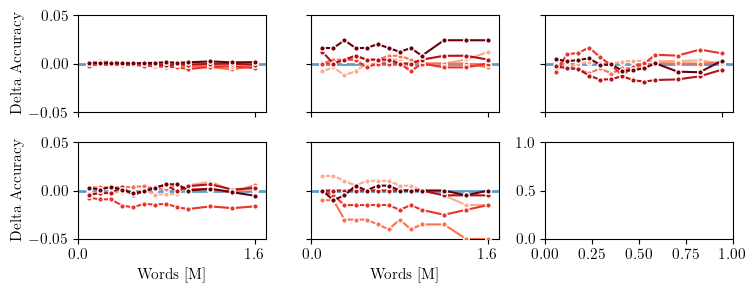

In [187]:
import matplotlib as mpl

# Place panels: ...3 col by 2 row grid, with reading always bottom-right, wug always bottom-middle
MAIN_TASKS = [t for t in df['scenario'].unique()
              if t not in ["reading", "wug_adj_nominalization"]]
# Sort for aesthetics
panel_order = MAIN_TASKS[:4] + ["wug_adj_nominalization", "reading"]
n_tasks = len(panel_order)
n_cols = 3
n_rows = int(np.ceil(n_tasks / n_cols))
markersize = 4
mec = "white" # markeredgecolor

width_pt = 200
figsize = set_size(width_pt, fraction=1, aspect_ratio=0.4)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()

# Get a red colormap (skip the lightest and darkest for better contrast)
red_cmap = plt.get_cmap("Reds")
n_ppos = len(models_ppo)
ppo_colors = [red_cmap(0.3 + 0.7*i/(n_ppos-1)) for i in range(n_ppos)]  # from lighter to darker red

# Optionally, make a mapping: model_name → color
MODEL_COLORS = dict(zip(models_ppo, ppo_colors))

for idx, task in enumerate(panel_order):
    ax = axes[idx]
    task_df = df[df['scenario'] == task]
    if task == "reading":
        # (skipped as per instructions)
        continue
    # Get and sort baseline by revision number
    baseline_df = task_df[task_df['model_name'] == baseline].sort_values('revision_number')
    x_base = baseline_df['revision_number'].values
    y_base = (baseline_df['average_accuracy'].values) / 100

    # Prepare baseline as a dict for quick lookup
    baseline_dict = dict(zip(x_base, y_base))

    for i, model_name in enumerate(models_ppo):
        dfm = task_df[task_df['model_name'] == model_name].sort_values('PPO_revision_number')
        x = dfm['revision_number'].values
        x_ppo = dfm['PPO_revision_number'].values / 1000
        y = (dfm['average_accuracy'].values) / 100

        # ...get baseline, compute delta_y as before...
        baseline_y = np.array([baseline_dict.get(xx, np.nan) for xx in x])
        delta_y = y - baseline_y

        label = MODEL_DISPLAY.get(model_name, model_name)
        zorder = MODEL_ZORDER.get(model_name, 0)

        sc = ax.plot(x_ppo, delta_y, color=ppo_colors[i], marker='o', markersize=markersize,
                        markeredgecolor=mec, label=label + " vs. 90M-base", zorder=zorder)

    # Panel formatting as before
    ax.axhline(y=0, ls='-', color=MODEL_COLORS.get(baseline, None), lw = 2, alpha=0.7, label="No difference", zorder=0)
    ax.set_ylabel("Delta Accuracy" if idx % n_cols == 0 else "")
    ax.set_ylim(-0.05, 0.05)
    ax.set_xticks([0, 1.6])
    if idx % n_cols != 0:
        ax.set_yticklabels([])
    if idx // n_cols == n_rows - 1:
        ax.set_xlabel(r'Words [M]')
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.set_xlim(0, 1.7)
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    #display_title = TASK_DISPLAY.get(task, str(task))
    #ax.text(
    #    0.03, 0.93, display_title,
    #    fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
    #    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    #)


plt.tight_layout()
#plt.savefig("figs/BLM_eval_fast_BLiMP_diffs.pdf")
plt.show()

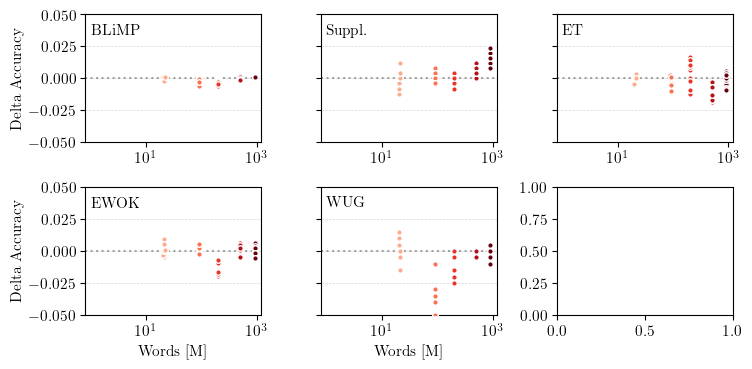

In [248]:
import matplotlib as mpl


# Place panels: ...3 col by 2 row grid, with reading always bottom-right, wug always bottom-middle
MAIN_TASKS = [t for t in df['scenario'].unique()
              if t not in ["reading", "wug_adj_nominalization"]]
# Sort for aesthetics
panel_order = MAIN_TASKS[:4] + ["wug_adj_nominalization", "reading"]
n_tasks = len(panel_order)
n_cols = 3
n_rows = int(np.ceil(n_tasks / n_cols))
markersize = 4
mec = "white" # markeredgecolor

width_pt = 300
figsize = set_size(width_pt, fraction=1, aspect_ratio=0.5)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()

# Get a red colormap (skip the lightest and darkest for better contrast)
red_cmap = plt.get_cmap("Reds")
n_ppos = len(models_ppo)
ppo_colors = [red_cmap(0.3 + 0.7*i/(n_ppos-1)) for i in range(n_ppos)]  # from lighter to darker red

# Optionally, make a mapping: model_name → color
MODEL_COLORS = dict(zip(models_ppo, ppo_colors))

for idx, task in enumerate(panel_order):
    ax = axes[idx]
    task_df = df[df['scenario'] == task]
    if task == "reading":
        # (skipped as per instructions)
        continue

    # Get and sort baseline by revision number
    baseline_df = task_df[task_df['model_name'] == baseline].sort_values('revision_number')
    x_base = baseline_df['revision_number'].values
    y_base = (baseline_df['average_accuracy'].values) / 100

    # Prepare baseline as a dict for quick lookup
    baseline_dict = dict(zip(x_base, y_base))

    for i, model_name in enumerate(models_ppo):
        dfm = task_df[task_df['model_name'] == model_name].sort_values('revision_number')
        x = dfm['revision_number'].values
        x_ppo = dfm['PPO_revision_number'].values / 1000
        y = (dfm['average_accuracy'].values) / 100

        # ...get baseline, compute delta_y as before...
        baseline_y = np.array([baseline_dict.get(xx, np.nan) for xx in x])
        delta_y = y - baseline_y

        label = MODEL_DISPLAY.get(model_name, model_name)
        zorder = MODEL_ZORDER.get(model_name, 0)

        sc = ax.scatter(x + x_ppo, delta_y, color=ppo_colors[i], marker='o', s=markersize**2,
                        edgecolor=mec, label=label, zorder=zorder)

    # Panel formatting as before
    ax.axhline(y=0, ls=':', color='gray', alpha=0.7, label="No difference", zorder=0)
    ax.set_ylabel("Delta Accuracy" if idx % n_cols == 0 else "")
    ax.set_ylim(-0.05, 0.05)
    if idx % n_cols != 0:
        ax.set_yticklabels([])
    if idx // n_cols == n_rows - 1:
        ax.set_xlabel(r'Words [M]')
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.set_xscale('log')
    ax.set_xlim(0.8, 1200)
    ax.xaxis.set_major_locator(LogLocator(base=10.0))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    display_title = TASK_DISPLAY.get(task, str(task))
    ax.text(
        0.03, 0.93, display_title,
        fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
    )


plt.tight_layout()
#plt.savefig("figs/BLM_eval_fast_BLiMP_diffs.pdf")
plt.show()

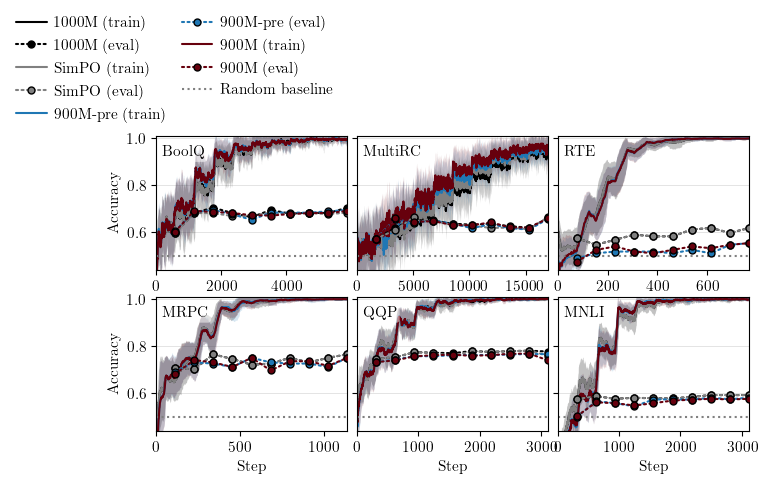

In [440]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d

roll_avg_window = 50
mec = "black"
markersize = 5
fontsize = 11

init_latex(fontsize)

# Group run_ids by task
# task_name -> [(model_label, color, history_df)]

task_runs = defaultdict(list)
for run_id, (task, model_label, color, history) in accuracy.items():
    # Un-LaTeX the task name for grouping
    task_name = task.replace("\\textbf{", "").replace("}", "")
    task_runs[task_name].append((model_label, color, history))

tasks = ["BoolQ", "MultiRC", "RTE", "MRPC", "QQP", "MNLI"]

figsize = set_size(ncols=2, aspect_ratio=0.5)
fig, axes = plt.subplots(2, 3, figsize=figsize)  # 6 subplots

for idx, task in enumerate(tasks):
    r, c = divmod(idx, 3)
    ax = axes[r, c]
    runs = task_runs[task]
    for model_label, color, history in runs:
        steps = history["_step"]
        train = history["train/accuracy"]

        # REMOVE THE TRACE OF TRAINING:
        # h1, = ax.plot(steps, train, color=color, alpha=0.1)

        # Compute rolling mean (centered by default in pandas)
        smoothed = train.rolling(roll_avg_window, min_periods=1).mean()
        ax.plot(steps, smoothed, color=color, label=f"{model_label} (train)")

        # Rolling standard deviation
        rolling_std = train.rolling(roll_avg_window, min_periods=1).std()
        lower = smoothed - rolling_std
        upper = smoothed + rolling_std

        ax.fill_between(
            steps, lower, upper,
            color=color, alpha=0.18, linewidth=0,
            label=None
        )

        eval_acc = history["evaluate/accuracy"]
        mask = eval_acc.notnull()
        eval_steps = steps[mask]
        eval_vals = eval_acc[mask]
        (line,) = ax.plot(eval_steps, eval_vals, color=color, linestyle=":",
                marker="o", markeredgecolor=mec, markersize=markersize, label=f"{model_label} (eval)", zorder = 5)
        line.set_dash_capstyle("round")
    ax.hlines(y=0.5, xmin=0, xmax=max(eval_steps), linestyle=":", color="gray", label='Random baseline')

    # Legends (just on first subplot)
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='lower right', ncol=2, frameon=False, handletextpad=0.5, columnspacing=1.0, bbox_to_anchor=(1, 1.))

    ax.text(0.03, 0.93, task, fontsize=fontsize, weight="bold", ha="left", va="top", transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.5))

    if c == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    if r == 1:
        ax.set_xlabel("Step")
    else:
        ax.set_xlabel("")

    ax.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_xlim(0, np.max(eval_steps))
    ax.set_ylim(0.44,1.01)

#plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0.05, hspace=0.2)
#plt.savefig("figs/BLM_eval_finetune.pdf")
plt.show()

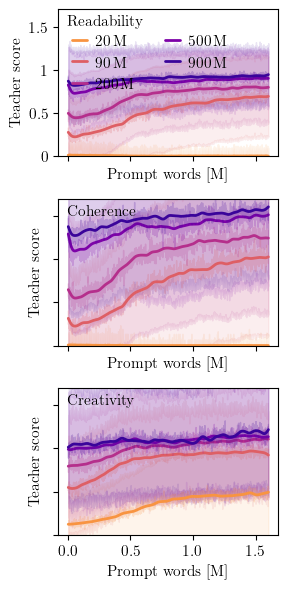

In [1303]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

score_list = ['Readability', 'Coherence', 'Creativity']
sigma = 20  # Smoothing std; adjust as desired


figsize = set_size(ncols=1, fraction=1, aspect_ratio=2)
fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

for idx, score in enumerate(score_list):
    ax = axes[idx]
    for color, revision in zip(colors, revision_numbers):
        df = batch_stats_dict[revision]
        prompt_words_M = df['prompt_words'].values / 1e6
        y = df[f'avg_{score}'].values
        y_std = df[f'std_{score}'].values

        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='nearest')

        ax.plot(prompt_words_M, y, alpha=0.2, color=color, linewidth=1)
        ax.plot(prompt_words_M, y_smooth, color=color, linewidth=2, label=rf"{revision}\,M")
        ax.fill_between(
            prompt_words_M,
            y_smooth - y_std,
            y_smooth + y_std,
            color=color, alpha=0.1
        )

        ax.set_ylim(0, 1.7)

    ax.set_ylabel("Teacher score")
    if idx != 0:
        ax.set_yticks([0, 0.5, 1, 1.5])
        ax.set_yticklabels([])
    else:
        ax.set_yticks([0, 0.5, 1, 1.5])
        ax.set_yticklabels(['0', '0.5', '1', '1.5'])
    ax.set_xlabel('Prompt words [M]')
    #ax.grid(True)

    ax.text(
        0.04, 0.96, score,
        va='top', ha='left',
        fontsize=ax.xaxis.label.get_size(),
        fontweight='bold',
        transform=ax.transAxes,
    )


axes[0].legend(frameon=False, handlelength=1, handletextpad=0.5, ncols=2, loc='upper left', bbox_to_anchor=(0.0, 0.92))
plt.tight_layout()
plt.savefig("figs/PPO_category_scores.pdf")
plt.show()

=== PDF actual area ===:
  451.00pt x 270.60pt  ||  6.2639in x 3.7584in
=== Your target figsize from set_size, corrected for fraction:
  451.00pt x 270.60pt  ||  6.2639in x 3.7584in
=== Ratio (actual/target):
  width: 100.00%,  height: 100.00%


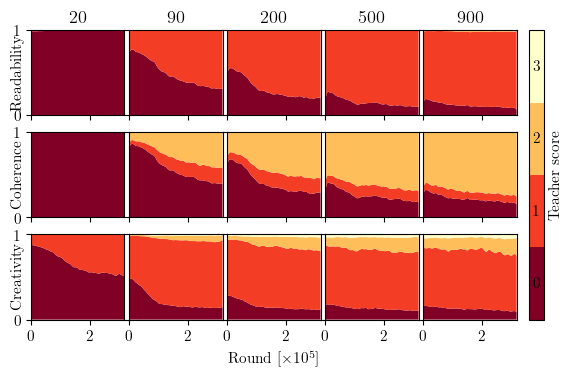

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter1d
import re

score_list = ['Readability', 'Coherence', 'Creativity']
possible_values = [0, 1, 2, 3]
cmap = plt.get_cmap('YlOrRd_r')
score_colors = [cmap(i / 3) for i in range(4)]

def revision_key(revision):
    m = re.match(r"(\d+)", str(revision))
    return int(m[1]) if m else float('inf')

revision_numbers = sorted(batch_stats_dict.keys(), key=revision_key)
n_models = len(revision_numbers)
n_scores = len(score_list)

fraction = 1.0
figsize = set_size(ncols=2, fraction=fraction, aspect_ratio=0.6)
fig, axes = plt.subplots(n_scores, n_models, figsize=figsize, sharex='col', sharey='row')

sigma = 20  # Smoothing
skip = 10 # plot only every nth point

for j, revision in enumerate(revision_numbers):
    df = batch_stats_dict[revision]
    interaction_round = df['interaction_round'].values / 1e5

    for i, score in enumerate(score_list):
        ax = axes[i, j] if n_models > 1 else axes[i]
        fraction_cols = [f"{score}_count_{v}" for v in possible_values]
        score_fractions = df[fraction_cols].values.T  # shape: (4, n_batches)
        smoothed_counts = np.array([
            gaussian_filter1d(row, sigma=sigma, mode='nearest')
            for row in score_fractions
        ])
        ax.stackplot(interaction_round[::skip], smoothed_counts[:,::skip], colors=score_colors, alpha=1)
        ax.set_xlim(interaction_round.min(), interaction_round.max())
        ax.set_ylim(0, 1)
        if j == 0:
            ax.set_ylabel(score, labelpad=-7)
        if i == 0:
            ax.set_title(f"{revision}")

# [left, bottom, width, height] in figure coordinates (0...1).
cbar_ax = fig.add_axes([0.92, 0.11, 0.023, 0.77])  # adjust as needed
boundaries = np.arange(-0.5, 4.5, 1)
sm = plt.cm.ScalarMappable(cmap=ListedColormap(score_colors), norm=plt.Normalize(vmin=0, vmax=3))
cbar = fig.colorbar(
    sm,
    cax=cbar_ax,
    boundaries=boundaries,
    ticks=possible_values,
    orientation='vertical',
)
cbar.set_label("Teacher score")
cbar.set_ticklabels([str(v) for v in possible_values])
cbar.set_ticks([])  # No ticks/labels on side

# Get position and height of the colorbar
cbar_axis = cbar.ax
cbar_pos = cbar_axis.get_position()
ymin, ymax = cbar_axis.get_ylim()
bin_height = (ymax - ymin) / len(possible_values)

for i, val in enumerate(possible_values):
    # Center of the ith bin
    y = ymin + (i + 0.5) * bin_height
    cbar_axis.text(
        0.55, y, str(val),
        ha='center', va='center',
        fontsize=11, color='black',
        transform=cbar_axis.transData
    )

for i in range(n_scores):
    for j in range(n_models):
        ax = axes[i, j] if n_models > 1 else axes[i]
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0', '1'])
        if i == n_scores - 1:
            if j == 2:
                ax.set_xlabel(r"Round [$\times 10^5$]", labelpad=5)

plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.savefig("figs/PPO_category_portions.pdf")
check_pdf_size("figs/PPO_category_portions.pdf", figsize, fraction)
plt.show()

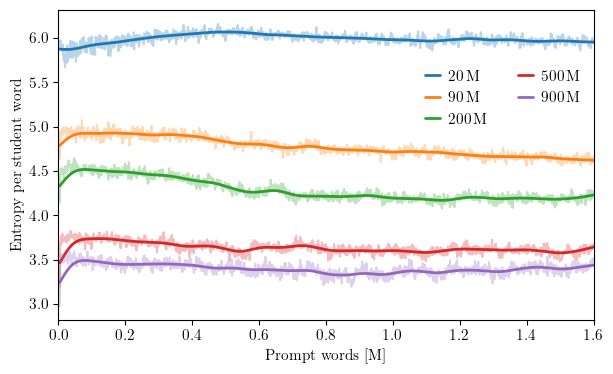

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

cmap = plt.get_cmap('tab10')
revision_numbers = sorted(
    batch_stats_dict.keys(),
    key=lambda x: int(str(x).replace('M',''))
)
n_models = len(revision_numbers)
colors = [cmap(i) for i in range(n_models)]
sigma = 30  # smoothing

figsize = set_size(width_pt = 150)
fig, ax = plt.subplots(figsize=figsize)

for color, revision in zip(colors, revision_numbers):
    df = batch_stats_dict[revision]
    # Compute entropy per word for each batch
    entropy_per_word = df['entropy'] / df['student_len']
    prompt_words_M = df['prompt_words'].values / 1e6

    entropy_per_word_np = entropy_per_word.to_numpy()
    entropy_per_word_smooth = gaussian_filter1d(entropy_per_word_np, sigma=sigma, mode='nearest')

    # Plot raw (faded) and smoothed (solid)
    ax.plot(prompt_words_M, entropy_per_word_np, alpha=0.3, color=color)
    ax.plot(prompt_words_M, entropy_per_word_smooth, linewidth=2, color=color, label=rf"{revision}\,M")

ax.set_xlim([0,1.6])
ax.set_xlabel('Prompt words [M]')
ax.set_ylabel('Entropy per student word')
ax.legend(frameon=False, handlelength=1, handletextpad=0.5, ncols=2, loc='upper right', bbox_to_anchor=(1.0, 0.85))
#ax.grid(True)
plt.tight_layout()
plt.savefig("figs/PPO_entropy.pdf")
plt.show()

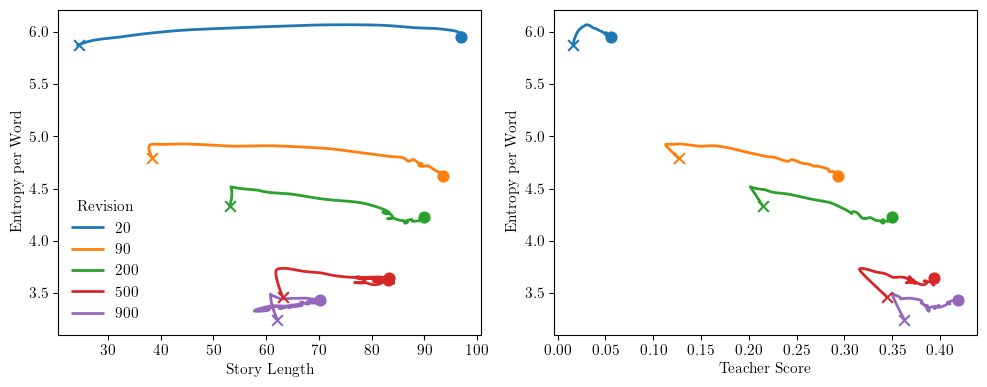

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 30
cmap = plt.get_cmap('tab10')
revision_numbers = sorted(
    batch_stats_dict.keys(),
    key=lambda x: int(str(x).replace('M',''))
)
colors = [cmap(i) for i in range(len(revision_numbers))]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for color, revision in zip(colors, revision_numbers):
    df = batch_stats_dict[revision]
    student_len = df['student_len'].to_numpy()
    entropy_per_word = (df['entropy'] / df['student_len']).to_numpy()
    score = df['avg_teacher_reward'].to_numpy()

    # Smooth all axes
    student_len_smooth = gaussian_filter1d(student_len, sigma=sigma, mode='nearest')
    entropy_per_word_smooth = gaussian_filter1d(entropy_per_word, sigma=sigma, mode='nearest')
    score_smooth = gaussian_filter1d(score, sigma=sigma, mode='nearest')

    # Panel 1: Story Length vs Entropy per Word
    axes[0].plot(student_len_smooth, entropy_per_word_smooth, linewidth=2, color=color, label=revision)
    # Start marker ("x")
    axes[0].scatter(student_len_smooth[0], entropy_per_word_smooth[0], marker='x', color=color, s=60, zorder=5)
    # End marker ("o")
    axes[0].scatter(student_len_smooth[-1], entropy_per_word_smooth[-1], marker='o', color=color, s=60, zorder=5)

    # Panel 2: Entropy per Word vs Teacher Score
    axes[1].plot(score_smooth, entropy_per_word_smooth, linewidth=2, color=color, label=revision)
    # Start marker ("x")
    axes[1].scatter(score_smooth[0], entropy_per_word_smooth[0], marker='x', color=color, s=60, zorder=5)
    # End marker ("o")
    axes[1].scatter(score_smooth[-1], entropy_per_word_smooth[-1], marker='o', color=color, s=60, zorder=5)

# Labels and layout
axes[0].set_xlabel('Story Length')
axes[0].set_ylabel('Entropy per Word')
axes[1].set_xlabel('Teacher Score')
axes[1].set_ylabel('Entropy per Word')

axes[0].legend(title="Revision", frameon=False)
plt.tight_layout()
plt.savefig("figs/PPO_entropy_v_reward.pdf")
plt.show()

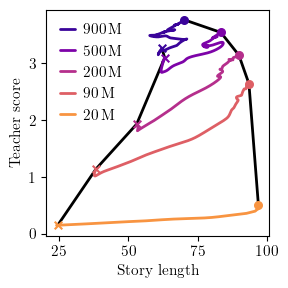

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 30

figsize=set_size(ncols=1, fraction=1.0, aspect_ratio=1)
fig, ax = plt.subplots(figsize=figsize)

student_len_smooth_start = []
student_len_smooth_end = []
score_smooth_start = []
score_smooth_end = []

for color, revision in zip(ppo_colors, revision_numbers):
    df = batch_stats_dict[revision]
    story_len = df['student_len'].to_numpy()
    score = df['avg_score_sum'].to_numpy()

    # Smoothed curves
    score_smooth = gaussian_filter1d(score, sigma=sigma, mode='nearest')
    student_len_smooth = gaussian_filter1d(story_len, sigma=sigma, mode='nearest')

    student_len_smooth_start.append(student_len_smooth[0])
    student_len_smooth_end.append(student_len_smooth[-1])
    score_smooth_start.append(score_smooth[0])
    score_smooth_end.append(score_smooth[-1])

    # Plot raw data as faint points
    #ax.scatter(story_len, score, color=color, alpha=0.015, zorder=0)
    # Plot smoothed curve
    ax.plot(student_len_smooth, score_smooth, linewidth=2, color=color, label=rf"{revision}\,M")
    # Start marker ("x")
    ax.scatter(student_len_smooth[0], score_smooth[0], marker='x', color=color, s=30, zorder=5)
    # End marker ("o")
    ax.scatter(student_len_smooth[-1], score_smooth[-1], marker='o', color=color, s=30, zorder=5)

ax.plot(student_len_smooth_start, score_smooth_start, linewidth=2, color="black", zorder=0)
ax.plot(student_len_smooth_end, score_smooth_end, linewidth=2, color="black", zorder=0)

ax.set_xlabel('Story length')
ax.set_ylabel('Teacher score')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False, handlelength=1, handletextpad=0.5)

fig.tight_layout()
fig.savefig("figs/PPO_score_v_length_plane.pdf")
plt.show()

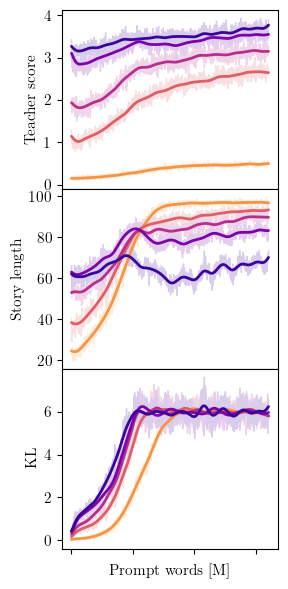

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

fields = [
    ('avg_score_sum', 'Teacher score'),
    ('student_len', 'Story length'),
    ('kl', 'KL'),
]

skip = 3
sigma = 30  # Smoothing std
markersize = 4

figsize = set_size(ncols=1, fraction=1, aspect_ratio=2)  # Taller since stacking
fig, axes = plt.subplots(
    3, 1, figsize=figsize, sharex=True,
    gridspec_kw={"hspace": 0}
)

for idx, (fieldname, fieldlabel) in enumerate(fields):
    ax = axes[idx]
    for color, revision in zip(ppo_colors, revision_numbers):
        df = batch_stats_dict[revision]
        prompt_words_M = df['prompt_words'].values / 1e6
        y = df[fieldname].values
        y_smooth = gaussian_filter1d(y, sigma=sigma, mode='nearest')

        pale = blend_with_white(mcolors.to_rgb(color), amount=0.8)
        ax.plot(prompt_words_M, y, color=pale, linewidth=1)
        ax.plot(prompt_words_M, y_smooth, color=color, linewidth=2, label=rf"{revision}\,M", zorder=3)

    # Add ylabel for each plot
    ax.set_ylabel(fieldlabel)

    # Remove xticklabels (but not ticks) for all but bottom plot
    if idx < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Prompt words [M]')

    # Optionally: adjust yticks
    # ax.set_yticks([0, .5, 1, 1.5])  # Or custom for each field

# Only show legend on the top axis
#axes[0].legend(frameon=False, handlelength=1, handletextpad=0.5, ncols=2, loc='upper left', bbox_to_anchor=(0.8, 1.0))

plt.tight_layout()
plt.savefig("figs/PPO_rewards.pdf")
plt.show()

=== PDF actual area ===:
  269.30pt x 258.42pt  ||  3.7402in x 3.5892in
=== Your target figsize from set_size, corrected for fraction:
  191.98pt x 191.98pt  ||  2.6664in x 2.6664in
=== Ratio (actual/target):
  width: 140.27%,  height: 134.61%


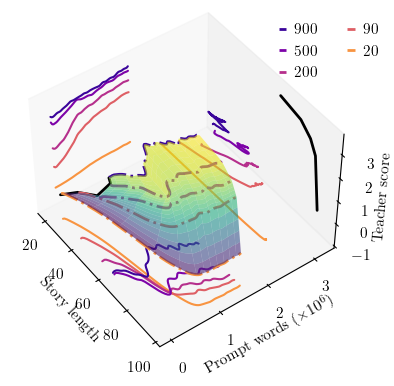

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

sigma = 30

# Build arrays for interpolation
all_rounds = np.concatenate([
    df['interaction_round'].values / 1e5 for df in batch_stats_dict.values()
])
prompt_grid = np.linspace(all_rounds.min(), all_rounds.max(), 130)

student_grid, score_grid = [], []
for revision in revision_numbers:
    df = batch_stats_dict[revision]
    prompt_words_M = df['prompt_words'].values / 1e6
    student = gaussian_filter1d(df['student_len'].values, sigma=sigma, mode='nearest')
    score = gaussian_filter1d(df['avg_score_sum'].values, sigma=sigma, mode='nearest')

    st_interp = interp1d(prompt_words_M, student, bounds_error=False, fill_value=np.nan)
    sc_interp = interp1d(prompt_words_M, score, bounds_error=False, fill_value=np.nan)

    student_grid.append(st_interp(prompt_grid))
    score_grid.append(sc_interp(prompt_grid))

student_grid = np.array(student_grid)
score_grid = np.array(score_grid)
PROMPTWORDS = np.tile(prompt_grid, (len(revision_numbers), 1))


from scipy.interpolate import interp1d

# Use current student_grid and score_grid: shape = (n_models, n_prompts)
n_models, n_prompts = student_grid.shape

# Define a denser fake "z" axis, e.g. 20 slices between models
dense_model_axis = np.linspace(0, n_models-1, 40)
dense_student = []
dense_score = []

for pi in range(n_prompts):
    # For this prompt step, interpolate across models between all original models
    student_across_models = student_grid[:, pi]
    score_across_models = score_grid[:, pi]
    f_student = interp1d(np.arange(n_models), student_across_models, kind="linear")
    f_score = interp1d(np.arange(n_models), score_across_models, kind="linear")
    dense_student.append(f_student(dense_model_axis))
    dense_score.append(f_score(dense_model_axis))

# Now, convert to arrays: shape (n_prompts, n_dense_models) → transpose for plotting
dense_student = np.array(dense_student).T  # shape (n_dense_models, n_prompts)
dense_score   = np.array(dense_score).T
dense_prompt  = np.tile(prompt_grid, (len(dense_model_axis), 1))

# Now plot as before, with higher "model" resolution:
figsize = set_size(ncols=1, fraction=1, aspect_ratio=1)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    dense_student,       # x
    dense_prompt,        # y
    dense_score,         # z
    cmap='viridis', # YlOrRd_r
    alpha=0.6,
    linewidth=0.5,
    ccount=30,
    rcount=30,
    edgecolor='None',
    antialiased=True,
    zorder=-1,
)

proj_score  = -1
proj_words  = 2.1
proj_length = 20
alpha_proj = 1.0
alpha_orig = 1.0

# Plot each revision's smoothed curve as line in 3D (x=student, y=prompt, z=score)
for student_curve, score_curve, color, rev_lab in zip(student_grid, score_grid, ppo_colors, revision_numbers):
    ax.plot(student_curve, prompt_grid, score_curve, color=color, lw=2, label=rf"{rev_lab}", linestyle='-.')
    #ax.scatter(student_curve[0], prompt_grid[0], score_curve[0], marker='x', color=color)
    #ax.scatter(student_curve[-1], prompt_grid[-1], score_curve[-1], marker='o', color=color)

    ax.scatter(proj_length + 0 * student_curve[0], prompt_grid[0], score_curve[0], marker='x', color=color, alpha=alpha_proj, zorder=-3)
    ax.scatter(proj_length + 0 * student_curve[-1], prompt_grid[-1], score_curve[-1], marker='o', color=color, alpha=alpha_proj, zorder=-3)
    ax.scatter(student_curve[0], proj_words + 0 * prompt_grid[0], score_curve[0], marker='x', color=color, alpha=alpha_proj, zorder=-3)
    ax.scatter(student_curve[-1], proj_words + 0 * prompt_grid[-1], score_curve[-1], marker='o', color=color, alpha=alpha_proj, zorder=-3)
    ax.scatter(student_curve[0], prompt_grid[0], proj_score + 0 * score_curve[0], marker='x', color=color, alpha=alpha_proj, zorder=-3)
    ax.scatter(student_curve[-1], prompt_grid[-1], proj_score + 0 * score_curve[-1], marker='o', color=color, alpha=alpha_proj, zorder=-3)

    ax.plot(proj_length + 0 * student_curve, prompt_grid,  score_curve, color=color, linestyle='-', alpha=alpha_proj, zorder=-3)
    ax.plot(student_curve, proj_words + 0 * prompt_grid,  score_curve, color=color, linestyle='-', alpha=alpha_proj, zorder=-3)
    ax.plot(student_curve, prompt_grid, proj_score + 0 * score_curve, color=color, linestyle='-', alpha=alpha_proj, zorder=-3)


ax.plot(student_len_smooth_start, np.min(prompt_grid) * np.ones(len(score_smooth_start)) , score_smooth_start, linewidth=2, color="black", zorder=-2)
ax.plot(student_len_smooth_end, np.max(prompt_grid) * np.ones(len(score_smooth_end)) , score_smooth_end, linewidth=2, color="black", zorder=-2)
#ax.plot(student_len_smooth_start, proj_words * np.ones(len(score_smooth_start)) , score_smooth_start, linewidth=2, color="black", zorder=-4)
#ax.plot(student_len_smooth_end, proj_words * np.ones(len(score_smooth_start)), score_smooth_start, linewidth=2, color="black", zorder=-4)

ax.set_xlabel("Story length", labelpad=-1)
ax.set_ylabel(r"Prompt words ($\times 10^6$)", labelpad=-1)
ax.set_zlabel("Teacher score", labelpad=-3)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False, handlelength=0.5, handletextpad=0.5, loc='upper left', bbox_to_anchor=(0.75,1.0), ncols=2)

ax.grid(False)

ax.view_init(elev=46, azim=-36, roll=0)
plt.savefig("figs/PPO_3D.pdf", bbox_inches='tight', pad_inches=0.12)
check_pdf_size("figs/default_tokenizer/PPO_3D.pdf", figsize, fraction)
plt.tight_layout()
plt.show()